# Tarea 3 - Deep Learning: Redes Neuronales Recurrentes (RNN)

Alumno: Adolfo Villalobos

In [0]:
import os
import json
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib as plt
from google.colab import drive
from torch.utils.data import Dataset, Subset, DataLoader

In [133]:
plt.rcParams['figure.figsize'] = [16, 8]

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path = '/content/gdrive/My Drive/Universidad/Universidad/7mo año/1er Semestre/Deep Learning/Tareas/Tarea 3'
os.chdir(path)

# 1. Calentando motores con RNNs

In [0]:
class AirlineDataset(Dataset):
  
    def __init__(self, dataset_path, input_length):
        super().__init__()
        
        self.input_length = input_length
        
        self._dataset = self._read_dataset(dataset_path)
        self.min_passengers = self._dataset.passengers.min()
        self.max_passengers = self._dataset.passengers.max()
    
    def normalize(self, data):
        return (data - self.min_passengers) / (self.max_passengers - self.min_passengers)
    
    def inverse_normalize(self, data):
        return data * (self.max_passengers - self.min_passengers) + self.min_passengers
        
    def _read_dataset(self, dataset_path):
        dataset_df = pd.read_csv(dataset_path)
        dataset_df.columns = ("month", "passengers")
        return dataset_df
    
    def __len__(self):
        return len(self._dataset) - self.input_length
    
    def __getitem__(self, idx):
        target_idx = idx + self.input_length
        prev_data = self._dataset.iloc[idx:target_idx].passengers.to_numpy()
        target = self._dataset.iloc[target_idx]
        return {
            "prev_data": torch.tensor(self.normalize(prev_data), dtype=torch.float),
            "target": torch.tensor(self.normalize(target.passengers), dtype=torch.float),
            "month": target.month
        }
      
class RNN(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear_out = nn.Linear(hidden_dim, 1).cuda()
        
    def forward(self, input):
        batch_size, _ = input.size()
        h0 = self.init_hidden(batch_size)
        _, hidden_state = self.rnn(input.unsqueeze(2), h0)
        out = self.linear_out(hidden_state.squeeze())
        return out
      
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda()
        return hidden
      
      
def num_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 1.1 Actividad 1

Sabemos que en el modelo de Vanilla RNN, las matrices de parámetros están dadas por $W_{xh}$, $W_{hh}$ y $W_{yh}$. Las dimensiones en juego son las siguientes: $d_x$ el tamaño del input, $d_h$ el tamaño de la capa escondida y $d_y$ el tamaño del output. 

En las slides de la clase, aparecen los espacios a los cuales pertenecen las matrices de parámetros:

$$
\begin{array}{rcl}
W_{xh} \in \mathbb{R}^{d_h\times d_x}, &  W_{hh} \in \mathbb{R}^{d_h\times d_h} ,& W_{yh} \in \mathbb{R}^{d_y\times d_h}
\end{array}
$$

Luego, la cantidad de parámetros sería la suma de las dimensiones de los espacios mencionados: $N = d_h\times d_x + d_h\times d_h+d_y\times d_h$.

Sin embargo, la expresión anteriorr no considera los bias en las transformaciones lineales. Para considerarlos, tenemos que reescribir los espacios de parámetros:

$$
\begin{array}{rcl}
W_{xh} \in \mathbb{R}^{d_h\times (d_x+1)}, &  W_{hh} \in \mathbb{R}^{d_h\times (d_h+1)} ,& W_{yh} \in \mathbb{R}^{d_y\times (d_h+1)}
\end{array}
$$

De esta manera, la cantidad de parámetros está dada por $N_{bias} = d_h\times (d_x+1)+d_h\times (d_h+1)+d_y\times (d_h+1)$. 

Para los ejemplos pedidos en el enunciado:

1. $d_x = 1$, $d_h=5$ y $d_y=1$. Se ve que la cantidad de parámetros sin considerar los bias es: $N=5\cdot1+5\cdot 5+1\cdot 5=5+25+5= 35$.  Al considerar los bias, la cantidad de parámetros es: $N_{bias} = 5\cdot (1+1)+5\cdot (5+1)+1\cdot (5+1) =10+30+6 = 46 $. Vemos que los bias agregaron 11 parámetros a la estimación total.

2. Ahora $d_x = 1$, $d_h=4$ y $d_y=1$. La cantidad de parámetros sin considerar los bias es $N=4\cdot1+4\cdot 4+1\cdot 4=4+16+4= 24$. Al considerar los bias, la cantidad de parámetros es $N_{bias} = 4\cdot (1+1)+4\cdot (4+1)+1\cdot (4+1) =8+20+5 = 33 $. Vemos que al considerar los bias, se aádieron 9 parámetros a la estimación total.

Al corroborar con el código entregado en el enucniado, se observa exactamente lo calculado.

In [0]:
input_dim = 1
hidden_dim = 5
num_layers = 1


model = RNN(input_dim, hidden_dim, num_layers)
params = num_trainable_parameters(model)
print("Cantidad de Parametros: {}".format(params))

Cantidad de Parametros: 46


In [0]:
input_dim = 1
hidden_dim = 4
num_layers = 1


model = RNN(input_dim, hidden_dim, num_layers)
params = num_trainable_parameters(model)
print("Cantidad de Parametros: {}".format(params))

Cantidad de Parametros: 33


Si analizamos matemáticamente,  veamos el efecto de reducir de $n$ a $n-1$ el tamaño del estado intermedio:

1. Para $d_h=n$, se tiene que $N=n+n^2+n = n^2+2n = n(n+2)$  mientras que $N_{bias} = 2n+n(n+1)+(n+1) = n^2+4n+1$. Luego, la cantidad  de parámetros añadidos al considerar el bias es $N_{bias}-N = 2n+1$.

2. Para $d_h=n-1$, se tiene que: $N=(n-1)+(n-1)^2+(n-1) = n^2-1$. Por otro lado, para   $N_{bias} = 2(n-1)+(n-1)n+n=n^2+2n-2$. La cantidad de parámetros añadidos al considerar el bias es $N_{bias}-N = 2n-1$.

Finalmente, si observamos la cantidad de parámetros que hay entre ambos casos es: $M = n^2+4n+1 -(n^2+2n-2) =2n+3 $. Vemos que esto es consistente para el caso que se ha visto en este ejemplo, pues para $n=5$, la discrepancia entre los dos casos es de $2\cdot5+3=13$ parámetros, que es justamente la diferencia entre 46 y 33.

Luego, se ha probado que la reducción de parámetros al reducir el tamaño de la capa intermedia en 1 será siempre de $2n+3$ parámetros, siendo $n$ el numero original de parámetros. 

Saber lo anterior es interesante ya que nos permite garantizar que el tamaño del problema escala linealmente con $d_h$ cuando $d_x=d_y=1$, y no multiplicativamente, como en el caso de las redes densas.

## 1.2 Actividad 2

In [136]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


In [0]:
import math

import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


def display_results(dataset, targets, predictions, val_start_idx, test_start_idx):
    # Desnormalizar los valores
    targets_inverse = dataset.inverse_normalize(targets)
    predictions_inverse = dataset.inverse_normalize(predictions)

    # Separar train/val/test
    train_predictions = np.empty_like(predictions)
    train_predictions[:] = np.nan
    train_predictions[:val_start_idx] = predictions_inverse[:val_start_idx]
    if test_start_idx - val_start_idx > 0:
        val_predictions = np.empty_like(predictions)
        val_predictions[:] = np.nan
        val_predictions[val_start_idx:test_start_idx] = predictions_inverse[val_start_idx:test_start_idx]
    test_predictions = np.empty_like(predictions)
    test_predictions[:] = np.nan
    test_predictions[test_start_idx:] = predictions_inverse[test_start_idx:]

    test_rmse = math.sqrt(mean_squared_error(targets_inverse[test_start_idx:], predictions_inverse[test_start_idx:]))
    # Imprimir RMSE
    print("Test RMSE: ", test_rmse)

    # Graficar targets y predicciones
    fig = plt.figure(figsize=(12, 8))
    plt.plot(targets_inverse, color="blue", label="Original")
    plt.plot(train_predictions, color="green", label="Predicho en entrenamiento")
    if test_start_idx - val_start_idx > 0:
        plt.plot(val_predictions, color="purple", label="Predicho en validación")
    plt.plot(test_predictions, color="red", label="Predicho en test")
    plt.legend(loc="upper left")
    plt.savefig("plot.png")
    
    return test_rmse



In [0]:
 
def main(MODEL, HISTORY_LENGTH, EPOCHS, BATCH_SIZE, LEARNING_RATE=0.005, **kwargs):
    # A continuación se definen un par de constantes
    DATASET_PATH = "international-airline-passengers.csv"
    TEST_START_IDX = 96 - HISTORY_LENGTH
    VAL_SPLIT = 0.2


    # Se lee el dataset y definen splits de train/val/test
    airline_ds = AirlineDataset(DATASET_PATH, HISTORY_LENGTH)
    train_val_ds = Subset(airline_ds, range(TEST_START_IDX))
    test_ds = Subset(airline_ds, range(TEST_START_IDX, len(airline_ds)))
    val_start_idx = int((1 - VAL_SPLIT) * len(train_val_ds))
    train_ds = Subset(train_val_ds, range(val_start_idx))
    val_ds = Subset(train_val_ds, range(val_start_idx, len(train_val_ds)))

    print("Size of train/val/test: ", len(train_ds), len(val_ds), len(test_ds))

    airline_dl = DataLoader(
        airline_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)
    train_dl = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True)
    val_dl = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)
    test_dl = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)

    # Se instancia el modelo, pérdida y optimizador
    rnn = MODEL(**kwargs)

    
    rnn.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)
    

    for epoch in range(1, EPOCHS + 1):
        train_losses = []
        val_losses = []
        test_losses = []
        for batch in train_dl:
            
            prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
            predicted = rnn(prev_data)
            loss = criterion(predicted.squeeze(), target)
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        mean_train_loss = np.mean(train_losses)
        with torch.no_grad():
            for batch in val_dl:
                prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
                predicted = rnn(prev_data)
                loss = criterion(predicted.squeeze(), target)
                val_losses.append(loss.item())
            mean_val_loss = np.mean(val_losses)
        if epoch % 100 == 0:
            print(f"Epoch #{epoch:>04d}: loss = {mean_train_loss:.5f}; val loss = {mean_val_loss:.5f}")

    # Evaluar sobre el dataset completo
    losses = []
    predictions = []
    targets = []
    with torch.no_grad():
        for batch in airline_dl:
            prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
            predicted = rnn(prev_data)
            predictions += predicted.squeeze().tolist()
            targets += target.tolist()
            loss = criterion(predicted.squeeze(), target)
            losses.append(loss.item())
        mean_loss = np.mean(losses)
    
        
    # Mostrar resultados
    test_rmse = display_results(
        dataset=airline_ds,
        targets=np.array(targets),
        predictions=np.array(predictions),
        val_start_idx=val_start_idx,
        test_start_idx=TEST_START_IDX
    )
    
    return test_rmse

### 1.2.1 Ejecución del modelo varias veces

A continuación se ejecuta el mismo experimento (con una misma configuración) un total de 10 veces.  

Al analizar el Output, se observa lo siguiente:

1. La curva de predicción es en general distinta en todos los casos. 
2. El valor del RMSE en la etapa de Test es distinto en todos los casos, lo cual continua por confirmar que para cada ejecución del experimento, se obtienen resultados distintos.

EXPERIMENTO Nº: 0
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test RMSE:  165.98609415176745
EXPERIMENTO Nº: 1
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test RMSE:  128.79166210569983
EXPERIMENTO Nº: 2
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test RMSE:  224.1447794393052
EXPERIMENTO Nº: 3
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test RMSE:  171.19012800488167
EXPERIMENTO Nº: 4
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test RMSE:  165.95874162305813


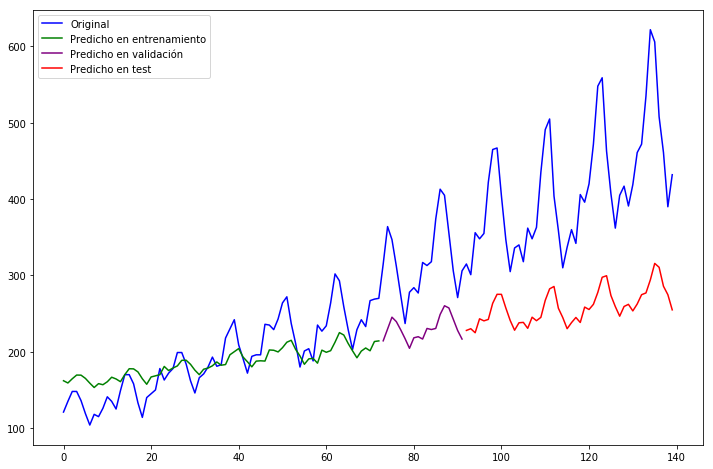

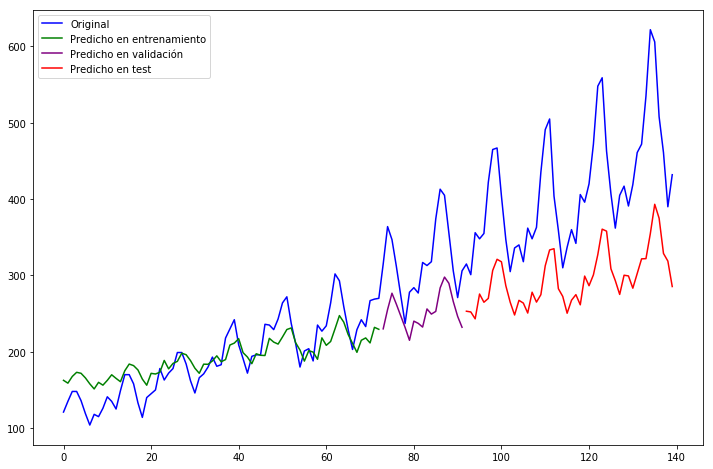

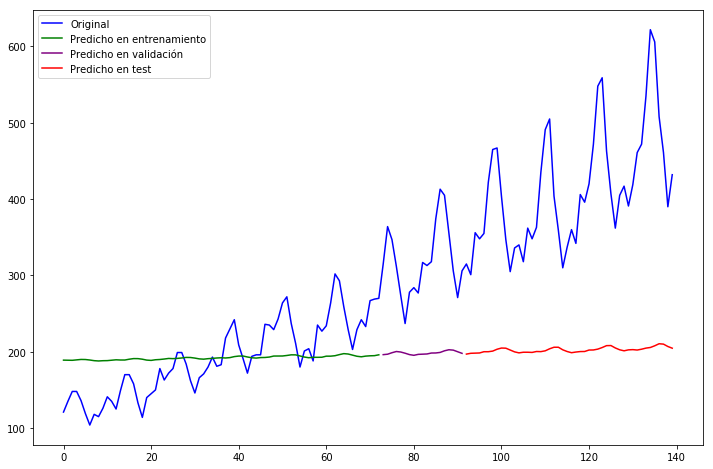

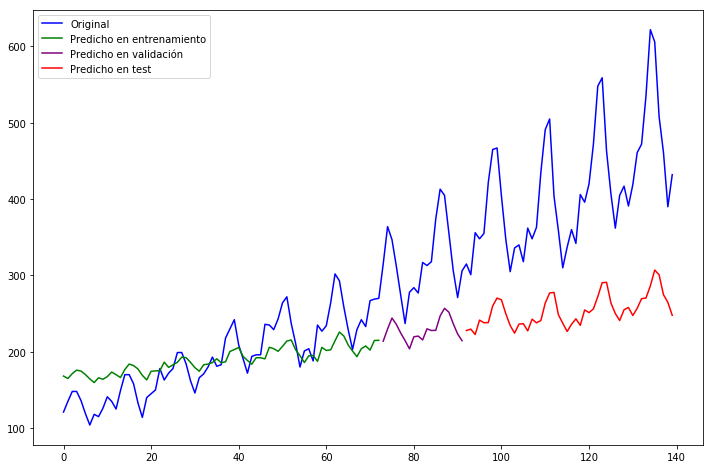

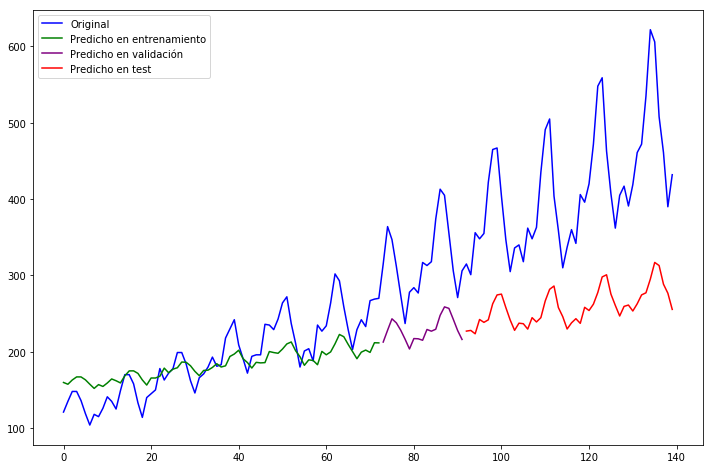

In [0]:
INPUT_DIM = 1
HIDDEN_DIM = 4
NUM_LAYERS = 1

HISTORY_LENGTH = 4

EPOCHS = 10
BATCH_SIZE = 8


NUM_EXPERIMENTS = 5
list_rmse1 = []

for i in range(NUM_EXPERIMENTS):
 
  print("EXPERIMENTO Nº: {}".format(i))
  test_rmse = main(RNN, HISTORY_LENGTH, EPOCHS, BATCH_SIZE, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM , num_layers=NUM_LAYERS)
  list_rmse1.append(test_rmse)

Efectivamente, si se guardan los RMSE de todos los experimentos, se puede constatar que hay variabilidad en el resultado. 

In [0]:
print("Test RMSE Obtenidos: {}".format(list_rmse1))


Test RMSE Obtenidos: [58.19924041831343, 67.08758329811316, 103.06093898781778, 83.98404725625853, 59.82553308156092]


Más aún, se observa que la desviación estándar de los RMSE es significativa con respecto al total, con lo cual se concluye una alta dispersión.

In [0]:
print("Media de los RMSE: {}".format(np.mean(list_rmse1)))
print("STD de los RMSE: {}".format(np.std(list_rmse1)))

Media de los RMSE: 74.43146860841276
STD de los RMSE: 16.980280145565036


**¿Por que ́ no se obtiene siempre el mismo resultado?. Fundamente su respuesta.**:


La razón por la cual no se obtiene los mismos resulotados siempre es debido a que la estimación de los parámetros del modelo depende de los datos de Entrenamiento y Validación. Si bien los datos de Testeo están fijos por construcción, los datos de Entrenamiento y Validación irán variando aleatoriamente de un experimento a otro, al utilizar el comando **Subset**. Esto tiene influencia directa en cómo se entrenan los parámetros, ya que este entrenamiento depende directamente del orden en que se le entreguen las secuencias de entrenamiento.



### 1.2.2 Modifique el largo de la secuencia de entrada. Indique como este cambio afecta la precisión de la predicción



EXPERIMENTO Nº: 0
Size of train/val/test:  70 18 48
Epoch #0100: loss = 0.00173; val loss = 0.00515
Epoch #0200: loss = 0.00147; val loss = 0.00413
Epoch #0300: loss = 0.00149; val loss = 0.00387
Epoch #0400: loss = 0.00151; val loss = 0.00374
Epoch #0500: loss = 0.00146; val loss = 0.00369
Epoch #0600: loss = 0.00136; val loss = 0.00351
Epoch #0700: loss = 0.00141; val loss = 0.00411
Epoch #0800: loss = 0.00134; val loss = 0.00477
Epoch #0900: loss = 0.00132; val loss = 0.00464
Epoch #1000: loss = 0.00132; val loss = 0.00379
Test RMSE:  63.67932952445688
EXPERIMENTO Nº: 1
Size of train/val/test:  70 18 48
Epoch #0100: loss = 0.00161; val loss = 0.00436
Epoch #0200: loss = 0.00144; val loss = 0.00443
Epoch #0300: loss = 0.00141; val loss = 0.00427
Epoch #0400: loss = 0.00182; val loss = 0.00557
Epoch #0500: loss = 0.00146; val loss = 0.00539
Epoch #0600: loss = 0.00143; val loss = 0.00587
Epoch #0700: loss = 0.00138; val loss = 0.00495
Epoch #0800: loss = 0.00138; val loss = 0.00664
Ep

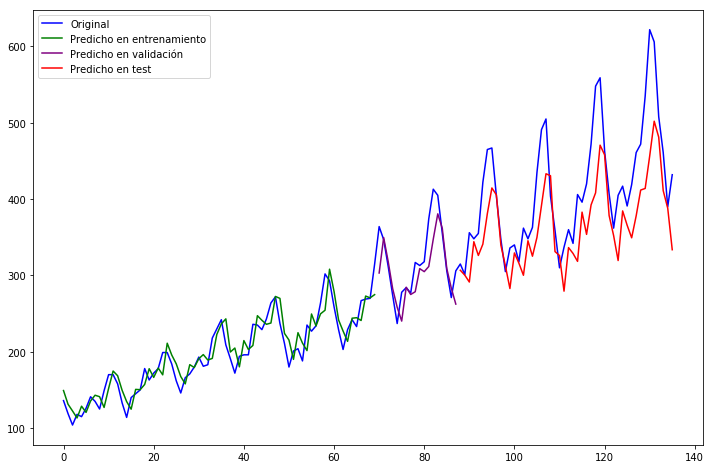

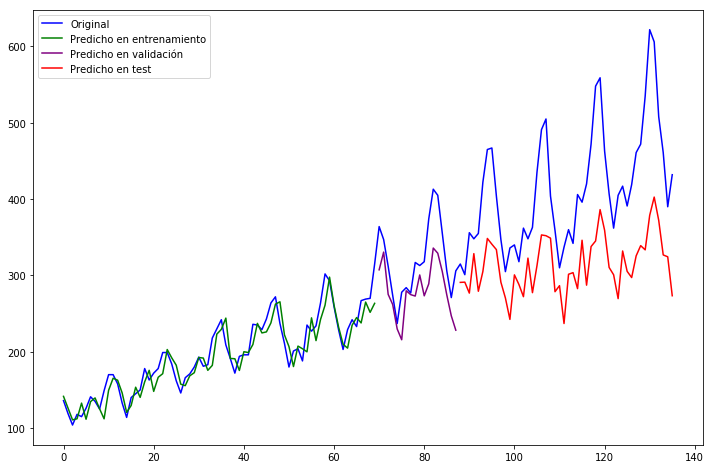

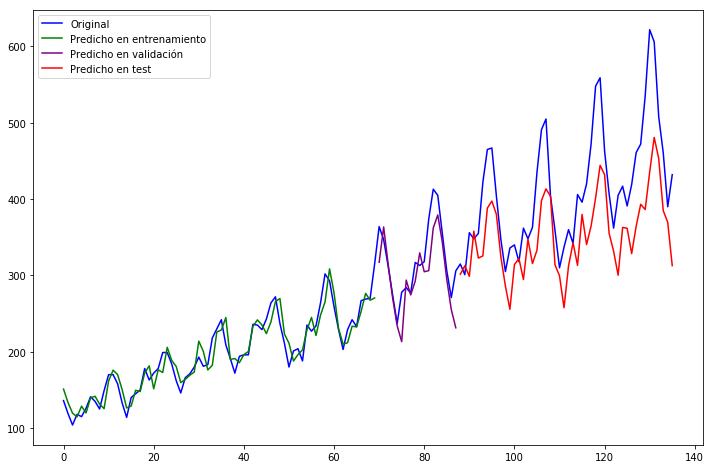

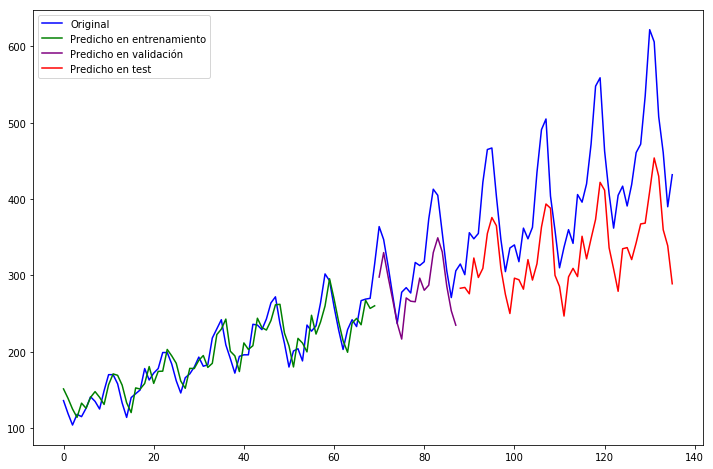

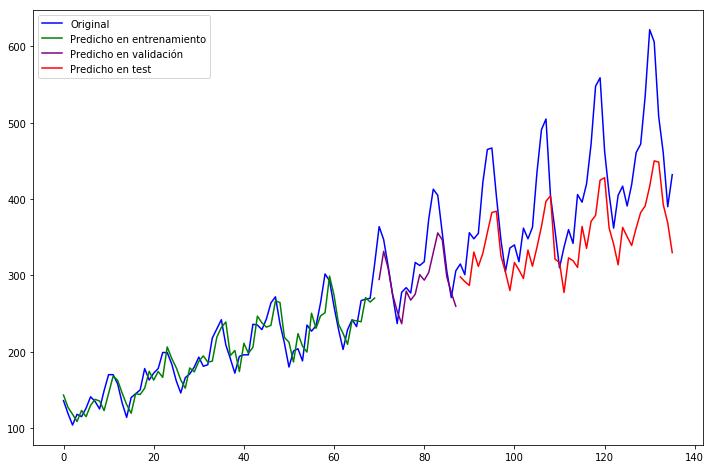

In [0]:
INPUT_DIM = 1
HIDDEN_DIM = 4
NUM_LAYERS = 1

HISTORY_LENGTH = 8

EPOCHS = 1000
BATCH_SIZE = 8


NUM_EXPERIMENTS = 5
list_rmse2 = []

for i in range(NUM_EXPERIMENTS):
 
  print("EXPERIMENTO Nº: {}".format(i))
  test_rmse2 = main(RNN, HISTORY_LENGTH, INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, EPOCHS, BATCH_SIZE)
  list_rmse2.append(test_rmse)

In [0]:
print("Test RMSE Obtenidos: {}".format(list_rmse2))

Test RMSE Obtenidos: [59.82553308156092, 59.82553308156092, 59.82553308156092, 59.82553308156092, 59.82553308156092]


In [0]:
print("Media de los RMSE: {}".format(np.mean(list_rmse2)))
print("STD de los RMSE: {}".format(np.std(list_rmse2)))

Media de los RMSE: 59.82553308156092
STD de los RMSE: 0.0


### 1.2.3 Agregue una nueva capa densa de 100 unidades antes de la capa lineal de salida. Indique como este cambio afecta la precisio ́n de la predicción.

Para realizar esto, redefinimos la clase **RNN** que venía en el enunciado:


In [0]:
class RNN_Dense(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 100)
        self.linear_out = nn.Linear(100, 1).cuda()
        
    def forward(self, input):
        batch_size, _ = input.size()
        h0 = self.init_hidden(batch_size)
        _, hidden_state = self.rnn(input.unsqueeze(2), h0)
        hidden_state = self.fc(hidden_state)
        out = self.linear_out(hidden_state.squeeze())
        return out
      
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda()
        return hidden

EXPERIMENTO Nº: 0
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00331; val loss = 0.00415
Epoch #0200: loss = 0.00130; val loss = 0.00404
Epoch #0300: loss = 0.00127; val loss = 0.00409
Epoch #0400: loss = 0.00116; val loss = 0.00529
Epoch #0500: loss = 0.00155; val loss = 0.00371
Epoch #0600: loss = 0.00121; val loss = 0.00413
Epoch #0700: loss = 0.00157; val loss = 0.00359
Epoch #0800: loss = 0.00113; val loss = 0.00608
Epoch #0900: loss = 0.00218; val loss = 0.00637
Epoch #1000: loss = 0.00148; val loss = 0.01227
Test RMSE:  116.32334781370199
EXPERIMENTO Nº: 1
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00161; val loss = 0.00633
Epoch #0200: loss = 0.00238; val loss = 0.00321
Epoch #0300: loss = 0.00137; val loss = 0.00475
Epoch #0400: loss = 0.00125; val loss = 0.00409
Epoch #0500: loss = 0.00139; val loss = 0.00501
Epoch #0600: loss = 0.00156; val loss = 0.00653
Epoch #0700: loss = 0.00198; val loss = 0.00668
Epoch #0800: loss = 0.00156; val loss = 0.00892
Epoch #0900: loss = 0.00165; val loss = 0.01234
Epoch #1000: loss = 0.00144; val loss = 0.00832
Test RMSE:  101.02831265160611
EXPERIMENTO Nº: 2
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00141; val loss = 0.00360
Epoch #0200: loss = 0.00235; val loss = 0.00456
Epoch #0300: loss = 0.00167; val loss = 0.00479
Epoch #0400: loss = 0.00233; val loss = 0.00305
Epoch #0500: loss = 0.00147; val loss = 0.00689
Epoch #0600: loss = 0.00115; val loss = 0.00500
Epoch #0700: loss = 0.00137; val loss = 0.00586
Epoch #0800: loss = 0.00120; val loss = 0.01085
Epoch #0900: loss = 0.00119; val loss = 0.01335
Epoch #1000: loss = 0.00182; val loss = 0.01034
Test RMSE:  111.87772353838344
EXPERIMENTO Nº: 3
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00205; val loss = 0.00426
Epoch #0200: loss = 0.00122; val loss = 0.00362
Epoch #0300: loss = 0.00138; val loss = 0.00432
Epoch #0400: loss = 0.00131; val loss = 0.00348
Epoch #0500: loss = 0.00152; val loss = 0.00366
Epoch #0600: loss = 0.00207; val loss = 0.00384
Epoch #0700: loss = 0.00129; val loss = 0.00532
Epoch #0800: loss = 0.00120; val loss = 0.00389
Epoch #0900: loss = 0.00128; val loss = 0.00493
Epoch #1000: loss = 0.00141; val loss = 0.00615
Test RMSE:  91.65810697699355
EXPERIMENTO Nº: 4
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00137; val loss = 0.00361
Epoch #0200: loss = 0.00129; val loss = 0.00601
Epoch #0300: loss = 0.00173; val loss = 0.00444
Epoch #0400: loss = 0.00144; val loss = 0.00458
Epoch #0500: loss = 0.00158; val loss = 0.00375
Epoch #0600: loss = 0.00129; val loss = 0.00378
Epoch #0700: loss = 0.00135; val loss = 0.00367
Epoch #0800: loss = 0.00133; val loss = 0.00413
Epoch #0900: loss = 0.00121; val loss = 0.00424
Epoch #1000: loss = 0.00152; val loss = 0.00413
Test RMSE:  58.50102916627217


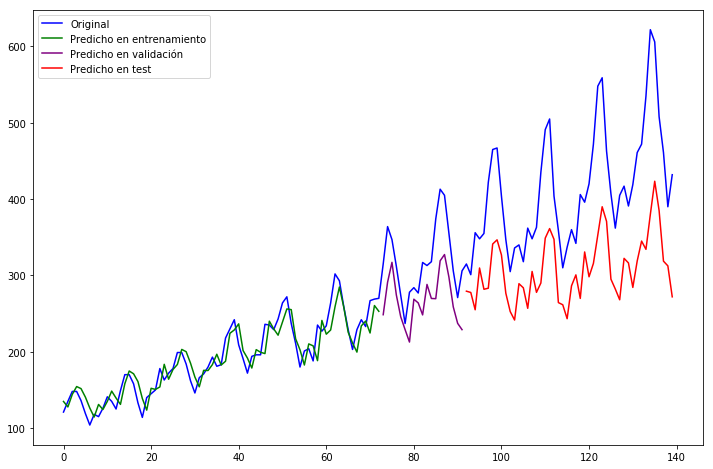

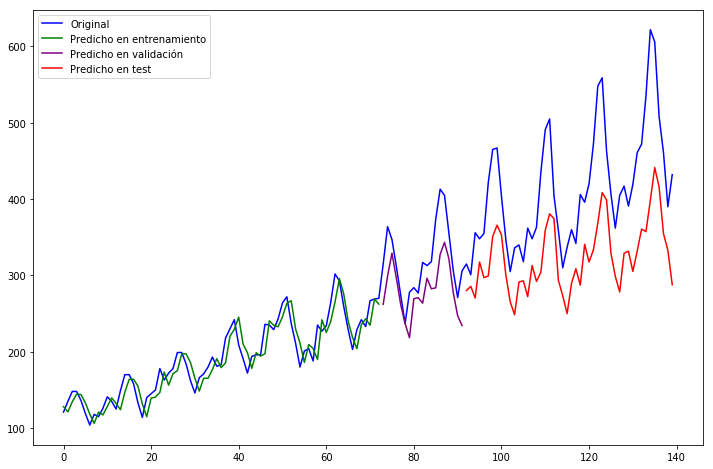

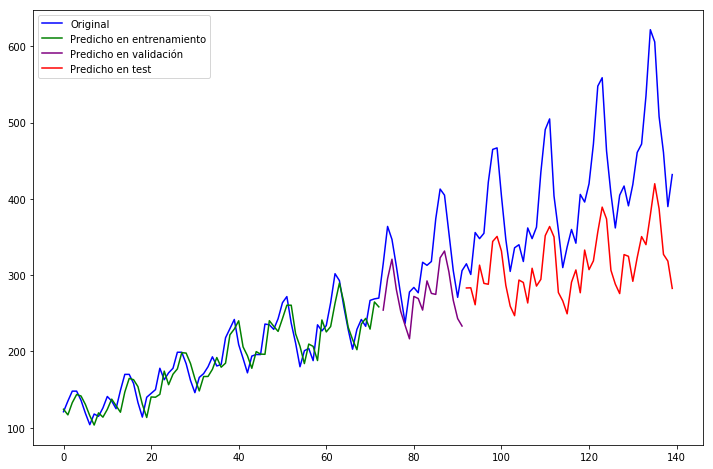

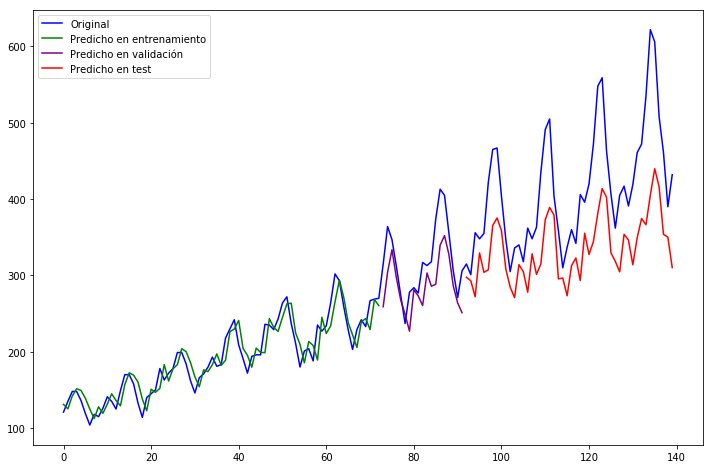

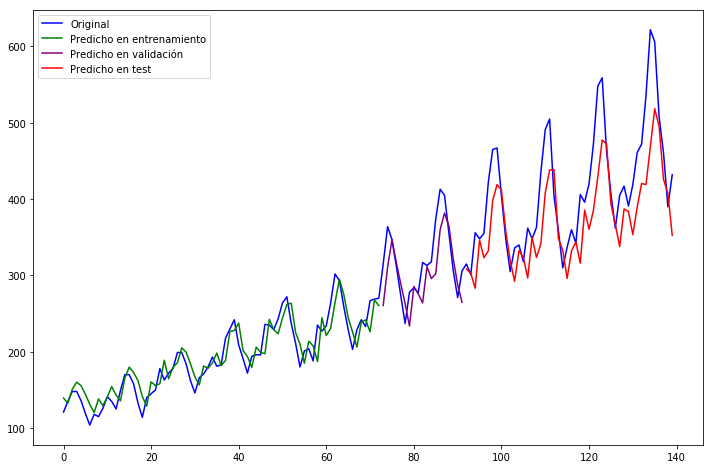

In [0]:
INPUT_DIM = 1
HIDDEN_DIM = 4
NUM_LAYERS = 1

HISTORY_LENGTH = 4

EPOCHS = 1000
BATCH_SIZE = 8


NUM_EXPERIMENTS = 5
list_rmse3 = []

for i in range(NUM_EXPERIMENTS):
 
  print("EXPERIMENTO Nº: {}".format(i))
  test_rmse = main(RNN_Dense, HISTORY_LENGTH, EPOCHS, BATCH_SIZE, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM , num_layers=NUM_LAYERS)
  list_rmse3.append(test_rmse)

In [0]:
print("Test RMSE Obtenidos: {}".format(list_rmse3))

Test RMSE Obtenidos: [116.32334781370199, 101.02831265160611, 111.87772353838344, 91.65810697699355, 58.50102916627217]


In [0]:
print("Media de los RMSE: {}".format(np.mean(list_rmse3)))
print("STD de los RMSE: {}".format(np.std(list_rmse3)))

Media de los RMSE: 95.87770402939145
STD de los RMSE: 20.56878492439556


EXPERIMENTO Nº: 0
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00169; val loss = 0.00507
Epoch #0200: loss = 0.00137; val loss = 0.00372
Epoch #0300: loss = 0.00203; val loss = 0.00769
Epoch #0400: loss = 0.00165; val loss = 0.00533
Epoch #0500: loss = 0.00124; val loss = 0.00392
Epoch #0600: loss = 0.00186; val loss = 0.00474
Epoch #0700: loss = 0.00135; val loss = 0.00589
Epoch #0800: loss = 0.00152; val loss = 0.00468
Epoch #0900: loss = 0.00132; val loss = 0.00445
Epoch #1000: loss = 0.00133; val loss = 0.00486
Test RMSE:  70.25088693850503
EXPERIMENTO Nº: 1
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00251; val loss = 0.00380
Epoch #0200: loss = 0.00178; val loss = 0.00560
Epoch #0300: loss = 0.00183; val loss = 0.00579
Epoch #0400: loss = 0.00132; val loss = 0.00504
Epoch #0500: loss = 0.00130; val loss = 0.00353
Epoch #0600: loss = 0.00150; val loss = 0.00366
Epoch #0700: loss = 0.00172; val loss = 0.00374
Epoch #0800: loss = 0.00146; val loss = 0.00402
Epoch #0900: loss = 0.00126; val loss = 0.00354
Epoch #1000: loss = 0.00121; val loss = 0.00408
Test RMSE:  55.22246904625281
EXPERIMENTO Nº: 2
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00147; val loss = 0.00410
Epoch #0200: loss = 0.00357; val loss = 0.00354
Epoch #0300: loss = 0.00124; val loss = 0.00381
Epoch #0400: loss = 0.00135; val loss = 0.00391
Epoch #0500: loss = 0.00217; val loss = 0.00400
Epoch #0600: loss = 0.00132; val loss = 0.00362
Epoch #0700: loss = 0.00134; val loss = 0.00418
Epoch #0800: loss = 0.00130; val loss = 0.00377
Epoch #0900: loss = 0.00133; val loss = 0.00429
Epoch #1000: loss = 0.00135; val loss = 0.00523
Test RMSE:  64.72385961879898
EXPERIMENTO Nº: 3
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00172; val loss = 0.00468
Epoch #0200: loss = 0.00201; val loss = 0.00446
Epoch #0300: loss = 0.00136; val loss = 0.00396
Epoch #0400: loss = 0.00152; val loss = 0.00384
Epoch #0500: loss = 0.00152; val loss = 0.00579
Epoch #0600: loss = 0.00152; val loss = 0.00512
Epoch #0700: loss = 0.00123; val loss = 0.00393
Epoch #0800: loss = 0.00137; val loss = 0.00435
Epoch #0900: loss = 0.00166; val loss = 0.00593
Epoch #1000: loss = 0.00155; val loss = 0.00375
Test RMSE:  82.10194170263316
EXPERIMENTO Nº: 4
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00141; val loss = 0.00445
Epoch #0200: loss = 0.00136; val loss = 0.00384
Epoch #0300: loss = 0.00163; val loss = 0.00426
Epoch #0400: loss = 0.00133; val loss = 0.00400
Epoch #0500: loss = 0.00137; val loss = 0.00443
Epoch #0600: loss = 0.00141; val loss = 0.00439
Epoch #0700: loss = 0.00123; val loss = 0.00376
Epoch #0800: loss = 0.00131; val loss = 0.00361
Epoch #0900: loss = 0.00172; val loss = 0.00354
Epoch #1000: loss = 0.00157; val loss = 0.00491
Test RMSE:  65.34793627501226


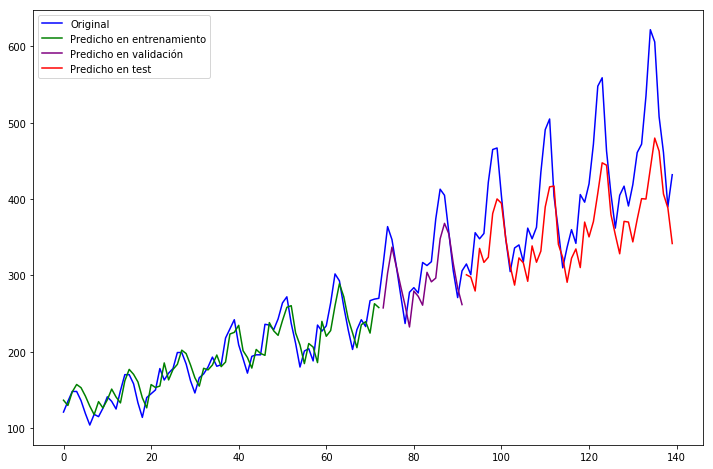

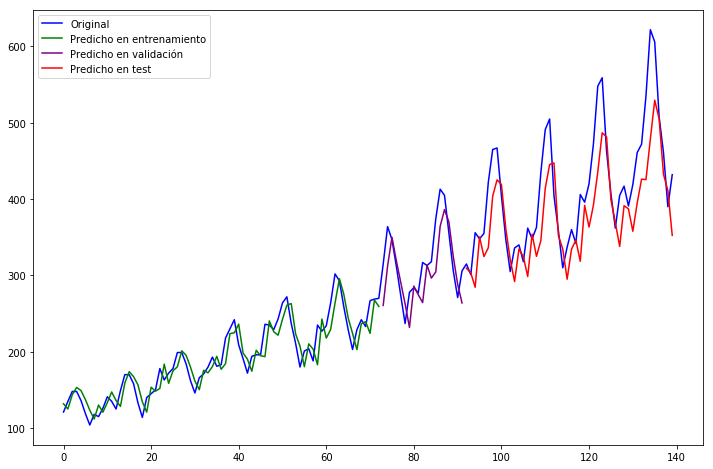

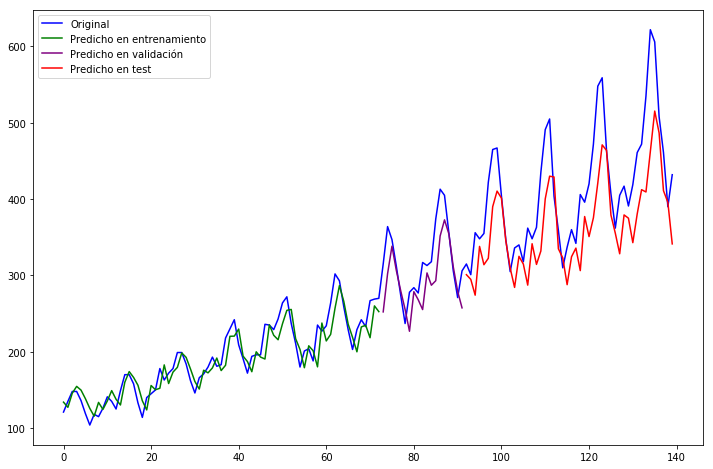

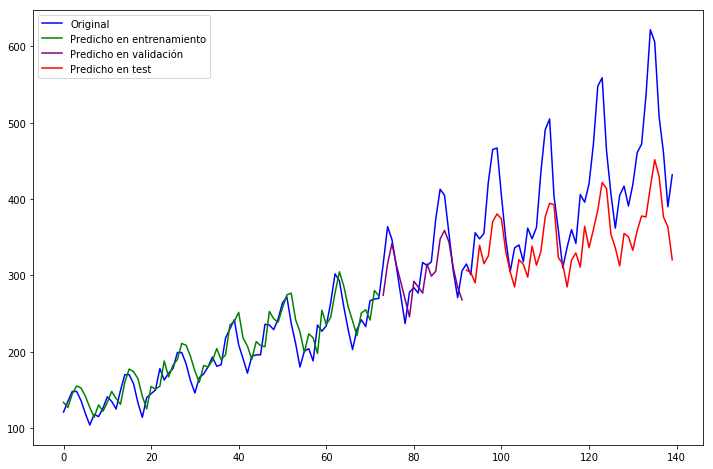

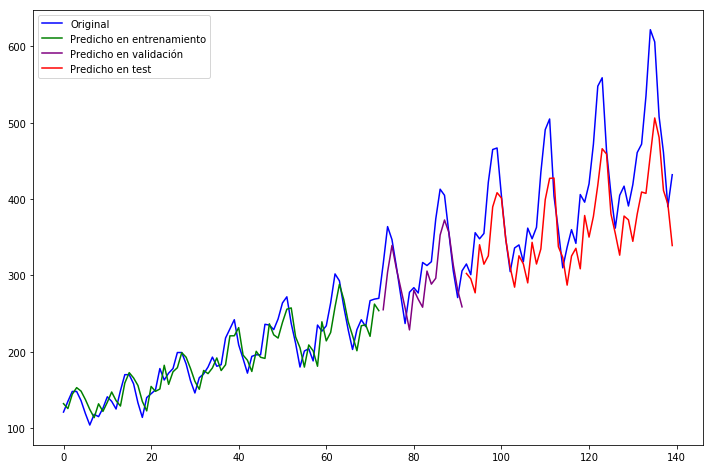

In [0]:
INPUT_DIM = 1
HIDDEN_DIM = 4
NUM_LAYERS = 1

HISTORY_LENGTH = 4

EPOCHS = 1000
BATCH_SIZE = 8


NUM_EXPERIMENTS = 5
list_rmse4 = []

for i in range(NUM_EXPERIMENTS):
 
  print("EXPERIMENTO Nº: {}".format(i))
  test_rmse = main(RNN_Dense, HISTORY_LENGTH, EPOCHS, BATCH_SIZE, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM , num_layers=NUM_LAYERS)
  list_rmse4.append(test_rmse)

In [0]:
print("Test RMSE Obtenidos: {}".format(list_rmse4))

Test RMSE Obtenidos: [70.25088693850503, 55.22246904625281, 64.72385961879898, 82.10194170263316, 65.34793627501226]


In [0]:
print("Media de los RMSE: {}".format(np.mean(list_rmse4)))
print("STD de los RMSE: {}".format(np.std(list_rmse4)))

Media de los RMSE: 67.52941871624044
STD de los RMSE: 8.761915922262345


### 1.2.4 Agregue una capa de Dropout. Indique como este cambio afecta la precisio ́n de la predicción

Se crea una nueva clase con la capa de Dropout pedida.

In [0]:
class RNN_Dropout(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.drop= nn.Dropout(p=0.5)
        self.linear_out = nn.Linear(hidden_dim, 1).cuda()
        
    def forward(self, input):
        batch_size, _ = input.size()
        h0 = self.init_hidden(batch_size)
        _, hidden_state = self.rnn(input.unsqueeze(2), h0)
        hidden_state = self.drop(hidden_state)
        out = self.linear_out(hidden_state.squeeze())
        return out
      
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda()
        return hidden

Se corren experimentos para tamaños de input 4 y 8

EXPERIMENTO Nº: 0
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00306; val loss = 0.01342
Epoch #0200: loss = 0.00277; val loss = 0.02354
Epoch #0300: loss = 0.00266; val loss = 0.01927
Epoch #0400: loss = 0.00209; val loss = 0.01585
Epoch #0500: loss = 0.00247; val loss = 0.01461
Epoch #0600: loss = 0.00262; val loss = 0.01318
Epoch #0700: loss = 0.00306; val loss = 0.01126
Epoch #0800: loss = 0.00330; val loss = 0.01130
Epoch #0900: loss = 0.00204; val loss = 0.01264
Epoch #1000: loss = 0.00270; val loss = 0.01903
Test RMSE:  125.28503483083024
EXPERIMENTO Nº: 1
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00282; val loss = 0.01893
Epoch #0200: loss = 0.00389; val loss = 0.01150
Epoch #0300: loss = 0.00354; val loss = 0.01464
Epoch #0400: loss = 0.00330; val loss = 0.01891
Epoch #0500: loss = 0.00311; val loss = 0.02035
Epoch #0600: loss = 0.00381; val loss = 0.01433
Epoch #0700: loss = 0.00218; val loss = 0.01422
Epoch #0800: loss = 0.00252; val loss = 0.01403
Epoch #0900: loss = 0.00246; val loss = 0.01952
Epoch #1000: loss = 0.00320; val loss = 0.01421
Test RMSE:  123.86246206819601
EXPERIMENTO Nº: 2
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00256; val loss = 0.01584
Epoch #0200: loss = 0.00253; val loss = 0.01854
Epoch #0300: loss = 0.00242; val loss = 0.01938
Epoch #0400: loss = 0.00363; val loss = 0.02948
Epoch #0500: loss = 0.00284; val loss = 0.01295
Epoch #0600: loss = 0.00349; val loss = 0.01865
Epoch #0700: loss = 0.00277; val loss = 0.01497
Epoch #0800: loss = 0.00316; val loss = 0.01162
Epoch #0900: loss = 0.00332; val loss = 0.01608
Epoch #1000: loss = 0.00238; val loss = 0.02163
Test RMSE:  109.57881378168638
EXPERIMENTO Nº: 3
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00393; val loss = 0.02316
Epoch #0200: loss = 0.00289; val loss = 0.02323
Epoch #0300: loss = 0.00361; val loss = 0.01637
Epoch #0400: loss = 0.00265; val loss = 0.02585
Epoch #0500: loss = 0.00396; val loss = 0.01274
Epoch #0600: loss = 0.00356; val loss = 0.01497
Epoch #0700: loss = 0.00405; val loss = 0.02176
Epoch #0800: loss = 0.00260; val loss = 0.02121
Epoch #0900: loss = 0.00326; val loss = 0.01628
Epoch #1000: loss = 0.00326; val loss = 0.02013
Test RMSE:  127.10947275712422
EXPERIMENTO Nº: 4
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00289; val loss = 0.01283
Epoch #0200: loss = 0.00305; val loss = 0.02098
Epoch #0300: loss = 0.00267; val loss = 0.01868
Epoch #0400: loss = 0.00354; val loss = 0.01864
Epoch #0500: loss = 0.00264; val loss = 0.01739
Epoch #0600: loss = 0.00317; val loss = 0.01383
Epoch #0700: loss = 0.00305; val loss = 0.00747
Epoch #0800: loss = 0.00335; val loss = 0.01637
Epoch #0900: loss = 0.00229; val loss = 0.00961
Epoch #1000: loss = 0.00271; val loss = 0.01668
Test RMSE:  115.87587119462438


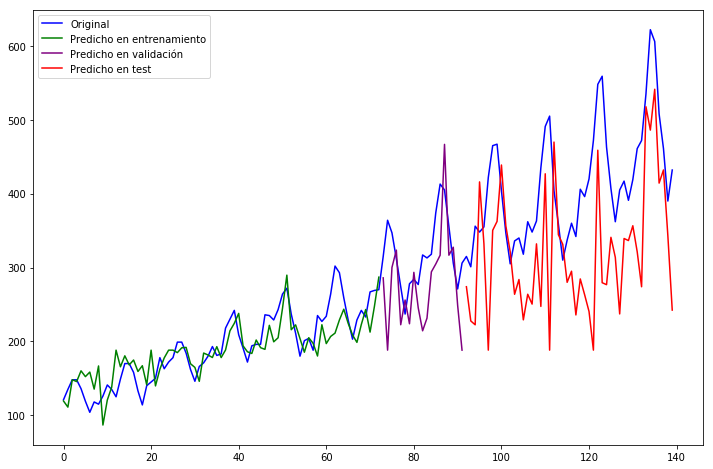

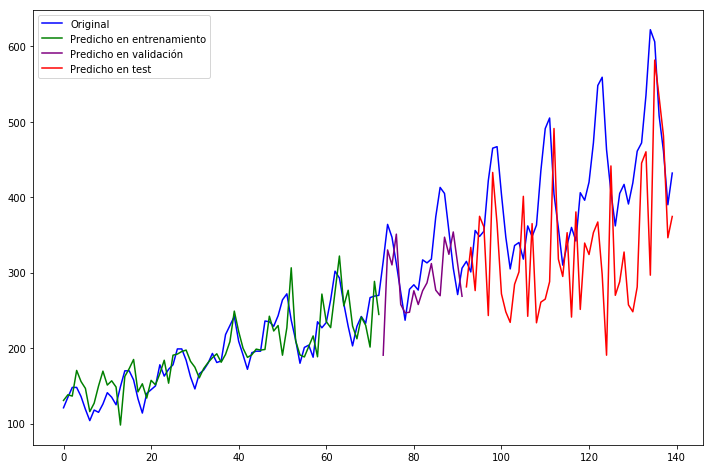

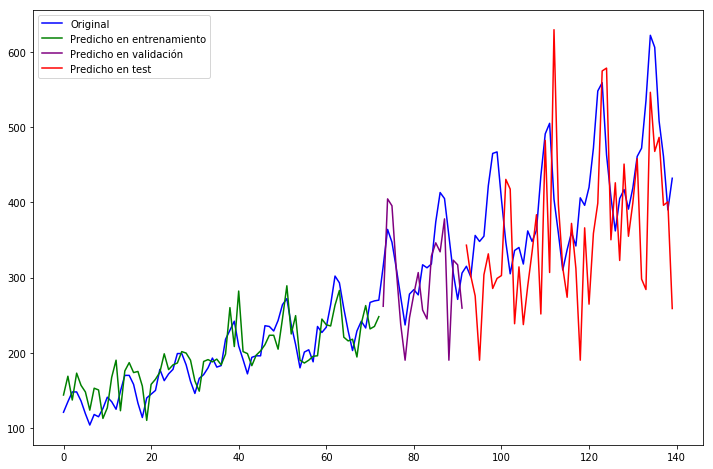

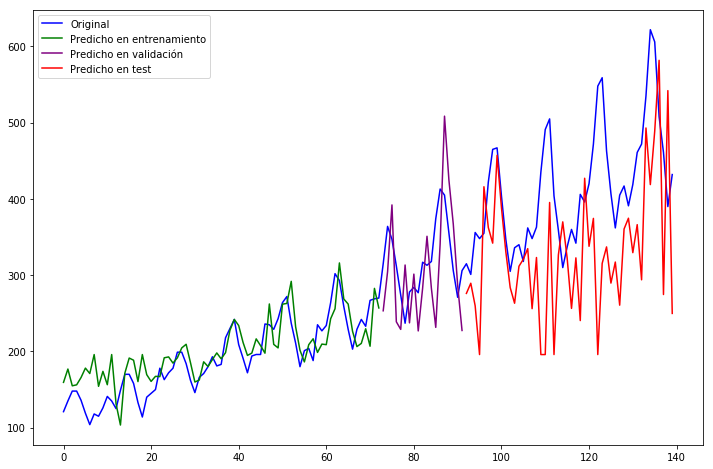

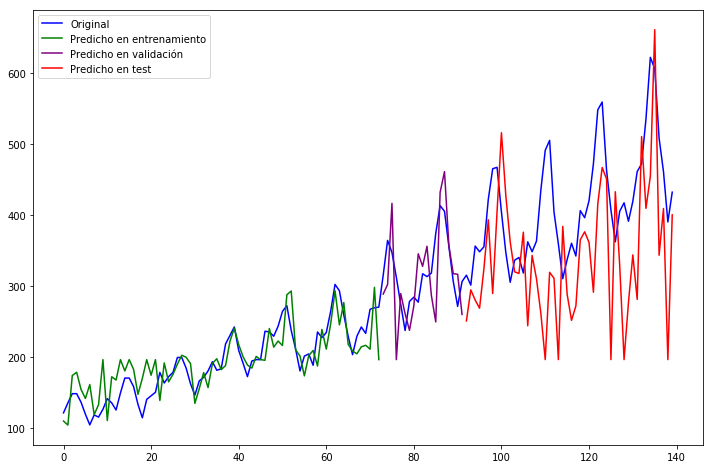

In [0]:
INPUT_DIM = 1
HIDDEN_DIM = 4
NUM_LAYERS = 1

HISTORY_LENGTH = 4

EPOCHS = 1000
BATCH_SIZE = 8


NUM_EXPERIMENTS = 5
list_rmse5 = []

for i in range(NUM_EXPERIMENTS):
 
  print("EXPERIMENTO Nº: {}".format(i))
  test_rmse = main(RNN_Dropout, HISTORY_LENGTH, EPOCHS, BATCH_SIZE, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM , num_layers=NUM_LAYERS)
  list_rmse5.append(test_rmse)

In [0]:
print("Test RMSE Obtenidos: {}".format(list_rmse5))

Test RMSE Obtenidos: [125.28503483083024, 123.86246206819601, 109.57881378168638, 127.10947275712422, 115.87587119462438]


In [0]:
print("Media de los RMSE: {}".format(np.mean(list_rmse5)))
print("STD de los RMSE: {}".format(np.std(list_rmse5)))

Media de los RMSE: 120.34233092649224
STD de los RMSE: 6.609363321221899


EXPERIMENTO Nº: 0
Size of train/val/test:  70 18 48
Epoch #0100: loss = 0.00376; val loss = 0.01742
Epoch #0200: loss = 0.00368; val loss = 0.01662
Epoch #0300: loss = 0.00403; val loss = 0.00955
Epoch #0400: loss = 0.00373; val loss = 0.01748
Epoch #0500: loss = 0.00301; val loss = 0.02389
Epoch #0600: loss = 0.00265; val loss = 0.01152
Epoch #0700: loss = 0.00287; val loss = 0.01647
Epoch #0800: loss = 0.00468; val loss = 0.00926
Epoch #0900: loss = 0.00344; val loss = 0.01665
Epoch #1000: loss = 0.00303; val loss = 0.01132
Test RMSE:  129.5004041148637
EXPERIMENTO Nº: 1
Size of train/val/test:  70 18 48
Epoch #0100: loss = 0.00463; val loss = 0.01661
Epoch #0200: loss = 0.00346; val loss = 0.01414
Epoch #0300: loss = 0.00318; val loss = 0.01501
Epoch #0400: loss = 0.00344; val loss = 0.01939
Epoch #0500: loss = 0.00268; val loss = 0.01209
Epoch #0600: loss = 0.00265; val loss = 0.01291
Epoch #0700: loss = 0.00209; val loss = 0.02198
Epoch #0800: loss = 0.00309; val loss = 0.01121
Ep

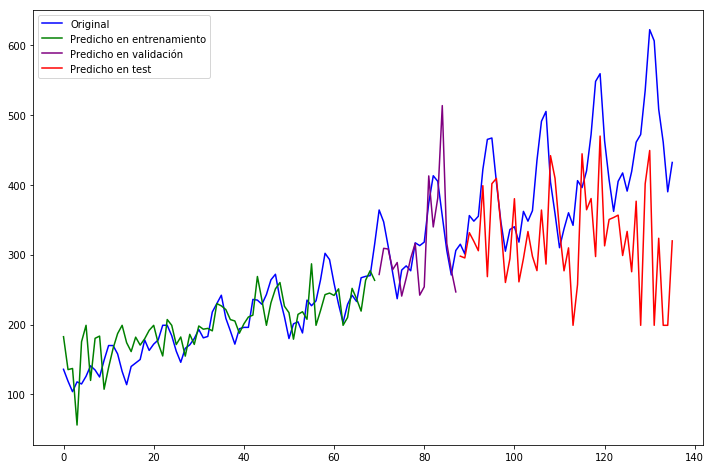

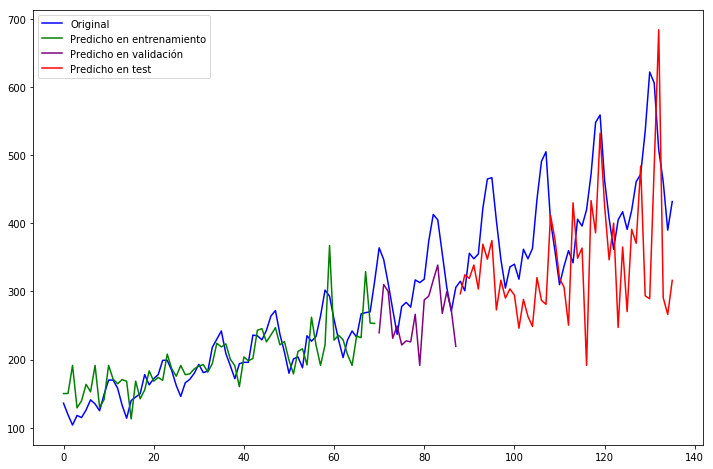

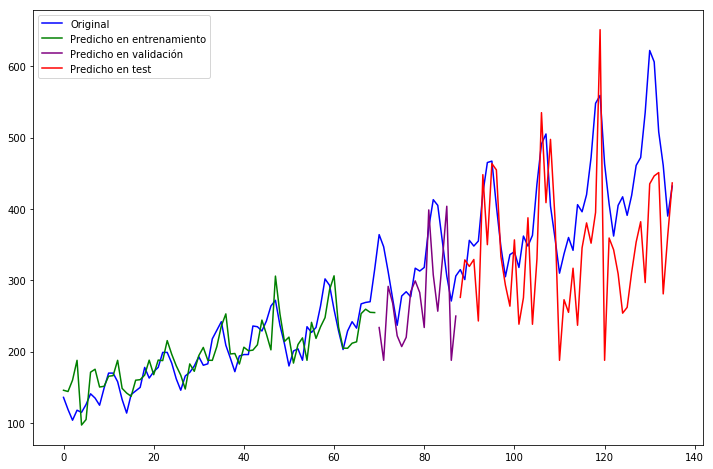

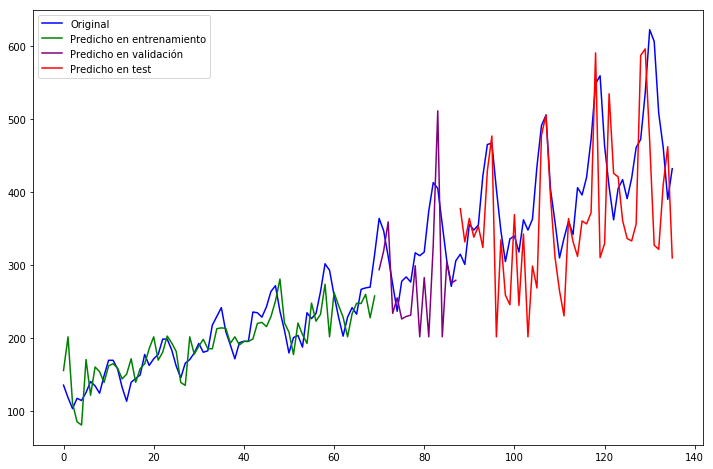

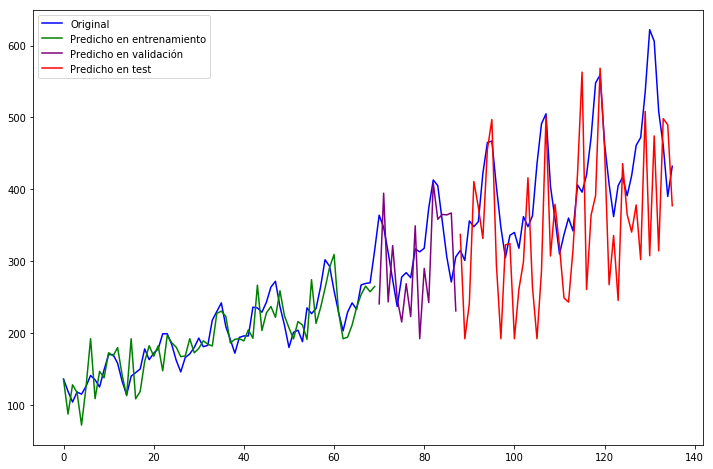

In [0]:
INPUT_DIM = 1
HIDDEN_DIM = 4
NUM_LAYERS = 1

HISTORY_LENGTH = 8

EPOCHS = 1000
BATCH_SIZE = 8


NUM_EXPERIMENTS = 5
list_rmse6 = []

for i in range(NUM_EXPERIMENTS):
 
  print("EXPERIMENTO Nº: {}".format(i))
  test_rmse = main(RNN_Dropout, HISTORY_LENGTH, EPOCHS, BATCH_SIZE, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM , num_layers=NUM_LAYERS)
  list_rmse6.append(test_rmse)

In [0]:
print("Test RMSE Obtenidos: {}".format(list_rmse6))

Test RMSE Obtenidos: [129.5004041148637, 114.00614454859516, 104.72920319532939, 98.79883580832914, 111.73160912292256]


Se observa que de todos los experimentos realizados, se obtiene un error promedio de 111.75 con una desviación estándar de 10.36

In [0]:
print("Media de los RMSE: {}".format(np.mean(list_rmse6)))
print("STD de los RMSE: {}".format(np.std(list_rmse6)))

Media de los RMSE: 111.753239358008
STD de los RMSE: 10.365245408714395


### 1.2.5 Análisis de los resultados obtenidos.

A continuación se analizan los resultados obtenidos:

1. Como se mencionó, en el experimento en la sección 1.2.1 (Experimento varias veces), hay variabilidad en los resultados, y en general el error es alto en la etapa de testeo, lo cual habla de un mal ajuste.
2. EN la sección 1.2.2, al duplicar el largo del tamaño del input, se obervan mejores resultados en cuanto al error y su variabilidad, sobre todo si este es igual al tamaño del batch (varianza 0). Al observar las gráficas, se observa que la curva prediccha es mucho más parecida a la real debido a lo anterior. 
3. En la sección 1.2.4, se observa que los resultados con Dropout son bastante malos: evidentemente hay pérdida en el parendizaje, con lo cual hay mayor varianza en el RMSE, además de que este parece ser elevado en comparación al resto de los experimentos.
4. En la sección 1.2.3 se observa los resultados con capa densa de 100 unidades. Se observa que al introducir esta nueva cantidad de parámetros, el modelo tiende a sobre ajustar y por lo tanto el error de predicción promedio (y su varianza) es aún mayor que en 1.2.1 y 1.2.2 en la etapa de testeo. Esto indica que un modelo mas complejo no es mejor para una serie de tiempo que parece ser tan sencilla.
5. Se observa que ninguno de todos los modelos logra tener un ajuste muy bueno. Esto probablemente se debe a la cantidad de datos: una red neuronal no funciona muy bien con pocos datos. Quizá para este tipo de problemas es mejor utilizar un modelo de serie de tiempo como un MA(k) o un AR(k).

## 1.3 Actividad 3

Se define una nueva clase para la base de datos ya que el input para una red LSTM tiene dimensiones distitnas a las de la red RNN entrenada anteriormente.

In [0]:
class AirlineDataset_LSTM(Dataset):
  
    def __init__(self, dataset_path, input_length):
        super().__init__()
        
        self.input_length = input_length
        
        self._dataset = self._read_dataset(dataset_path)
        self.min_passengers = self._dataset.passengers.min()
        self.max_passengers = self._dataset.passengers.max()
    
    def normalize(self, data):
        return (data - self.min_passengers) / (self.max_passengers - self.min_passengers)
    
    def inverse_normalize(self, data):
        return data * (self.max_passengers - self.min_passengers) + self.min_passengers
        
    def _read_dataset(self, dataset_path):
        dataset_df = pd.read_csv(dataset_path)
        dataset_df.columns = ("month", "passengers")
        return dataset_df
    
    def __len__(self):
        return len(self._dataset) - self.input_length
    
    def __getitem__(self, idx):
        target_idx = idx + self.input_length
        prev_data = self._dataset.iloc[idx:target_idx].passengers.to_numpy()
        target = self._dataset.iloc[target_idx]
        return {
            "prev_data": torch.tensor(self.normalize(prev_data), dtype=torch.float).unsqueeze(1),
            "target": torch.tensor(self.normalize(target.passengers), dtype=torch.float),
            "month": target.month
        }

Se define una función de entrenamiento acorde a lo anterior.

In [0]:
def main(MODEL, HISTORY_LENGTH, EPOCHS, BATCH_SIZE, LEARNING_RATE=0.005, **kwargs):
    # A continuación se definen un par de constantes
    DATASET_PATH = "international-airline-passengers.csv"
    TEST_START_IDX = 96 - HISTORY_LENGTH
    VAL_SPLIT = 0.2


    # Se lee el dataset y definen splits de train/val/test
    airline_ds = AirlineDataset_LSTM(DATASET_PATH, HISTORY_LENGTH)
    train_val_ds = Subset(airline_ds, range(TEST_START_IDX))
    test_ds = Subset(airline_ds, range(TEST_START_IDX, len(airline_ds)))
    val_start_idx = int((1 - VAL_SPLIT) * len(train_val_ds))
    train_ds = Subset(train_val_ds, range(val_start_idx))
    val_ds = Subset(train_val_ds, range(val_start_idx, len(train_val_ds)))

    print("Size of train/val/test: ", len(train_ds), len(val_ds), len(test_ds))

    airline_dl = DataLoader(
        airline_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)
    train_dl = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True)
    val_dl = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)
    test_dl = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)

    # Se instancia el modelo, pérdida y optimizador
    rnn = MODEL(**kwargs)

    
    rnn.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)
    

    for epoch in range(1, EPOCHS + 1):
        train_losses = []
        val_losses = []
        test_losses = []
        for batch in train_dl:
            
            prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
            predicted = rnn(prev_data)
            #print(predicted.shape)
            #print(target.unsqueeze(1).shape)
            loss = criterion(predicted, target.unsqueeze(1))
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        mean_train_loss = np.mean(train_losses)
        with torch.no_grad():
            for batch in val_dl:
                prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
                predicted = rnn(prev_data)
                loss = criterion(predicted.squeeze(), target)
                val_losses.append(loss.item())
            mean_val_loss = np.mean(val_losses)
        if epoch % 100 == 0:
            print(f"Epoch #{epoch:>04d}: loss = {mean_train_loss:.5f}; val loss = {mean_val_loss:.5f}")

    # Evaluar sobre el dataset completo
    losses = []
    predictions = []
    targets = []
    with torch.no_grad():
        for batch in airline_dl:
            prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
            predicted = rnn(prev_data)
            predictions += predicted.squeeze().tolist()
            targets += target.tolist()
            loss = criterion(predicted.squeeze(), target)
            losses.append(loss.item())
        mean_loss = np.mean(losses)
    
        
    # Mostrar resultados
    test_rmse = display_results(
        dataset=airline_ds,
        targets=np.array(targets),
        predictions=np.array(predictions),
        val_start_idx=val_start_idx,
        test_start_idx=TEST_START_IDX
    )
    
    return test_rmse

Luego, se define la clase para la red LSTM.

In [0]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, num_layers=self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as

        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        
        #print(input.shape)
        #print(input.view(input.shape[1], self.batch_size, self.input_dim).shape)
        out, self.hidden = self.lstm(input.view(input.shape[1], input.shape[0], input.shape[2]))
    
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        #print(out.shape)
        
        ypred = F.relu(self.linear(out[-1]))
        #print(ypred.shape)
        
        return(ypred)

Finalmente se ejecutan algunos experimentos.


**Primer Experimento** Se copian los parametros de entrada de la primera RNN

En el primer experimento se observa que los resultados son muy inferiores a los casos anteriores. Esl RSME es muy superior a los casos anteriores. En algunas instancias incluso no aprende nada, y en otrosd aprende bastante poco. Sin embargo, el costo computacional es bastante mayor ya que son mas parametros.

En los graficos al final de la siguiente celda se obserrva lo mencionado: un RMSE alto, y curvas planas que revelan nada de aprendizaje. 

EXPERIMENTO Nº: 0
Size of train/val/test:  73 19 48
Epoch #0100: loss = 0.03955; val loss = 0.17119
Epoch #0200: loss = 0.03955; val loss = 0.17119
Epoch #0300: loss = 0.03587; val loss = 0.17119
Epoch #0400: loss = 0.03673; val loss = 0.17119
Epoch #0500: loss = 0.03999; val loss = 0.17119
Epoch #0600: loss = 0.03525; val loss = 0.17119
Epoch #0700: loss = 0.03802; val loss = 0.17119
Epoch #0800: loss = 0.03394; val loss = 0.17119
Epoch #0900: loss = 0.03520; val loss = 0.17119
Epoch #1000: loss = 0.03587; val loss = 0.17119
Test RMSE:  319.0783293288522
EXPERIMENTO Nº: 1
Size of train/val/test:  73 19 48
Epoch #0100: loss = 0.03520; val loss = 0.17119
Epoch #0200: loss = 0.03654; val loss = 0.17119
Epoch #0300: loss = 0.04245; val loss = 0.17119
Epoch #0400: loss = 0.03888; val loss = 0.17119
Epoch #0500: loss = 0.03654; val loss = 0.17119
Epoch #0600: loss = 0.03525; val loss = 0.17119
Epoch #0700: loss = 0.03738; val loss = 0.17119
Epoch #0800: loss = 0.04266; val loss = 0.17119
Ep

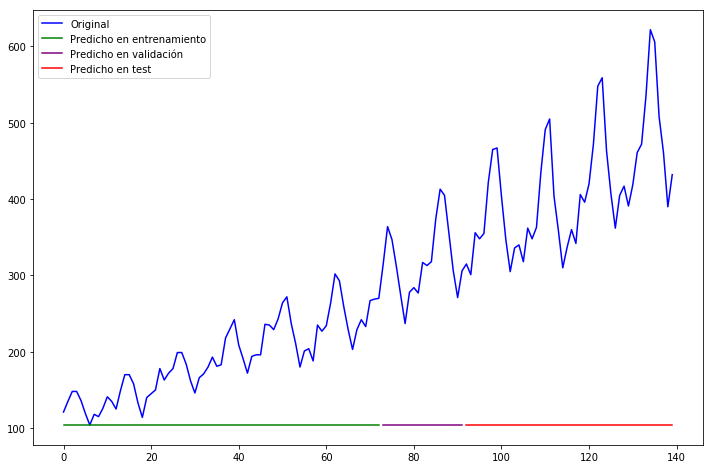

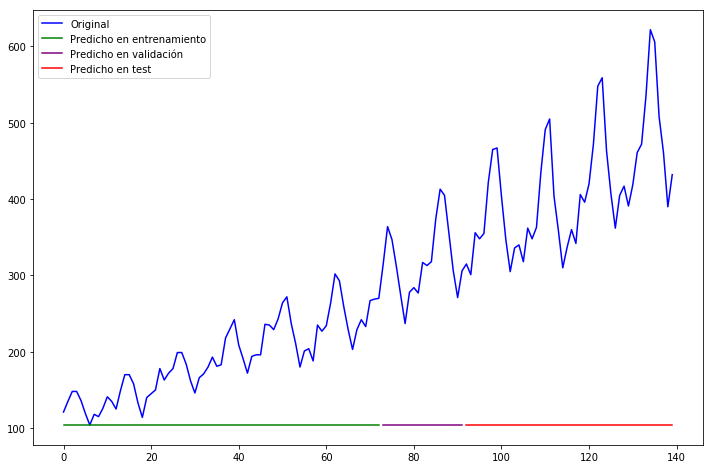

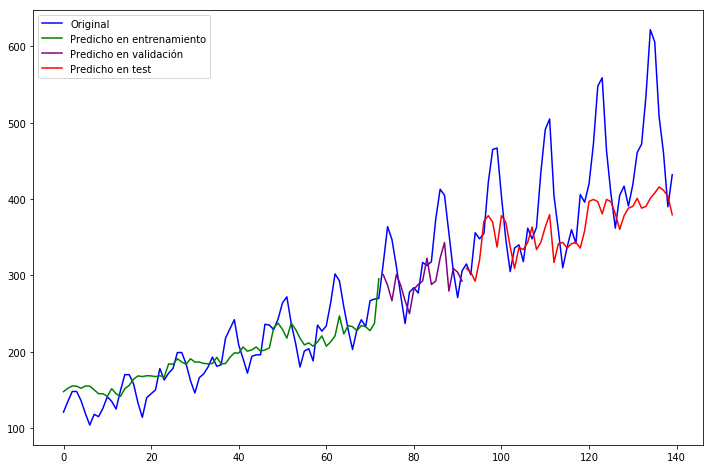

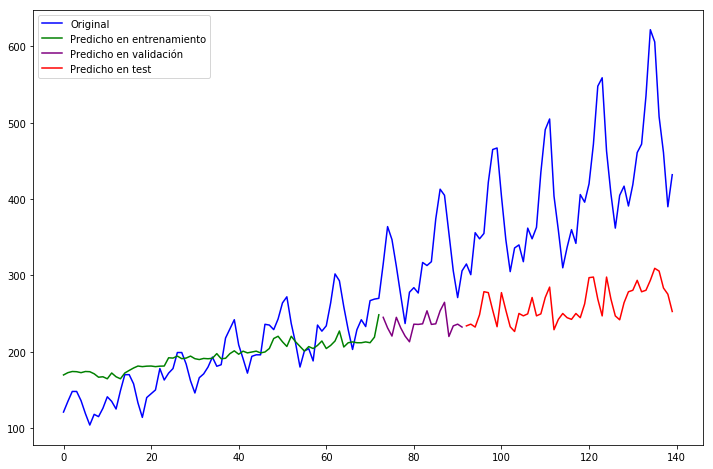

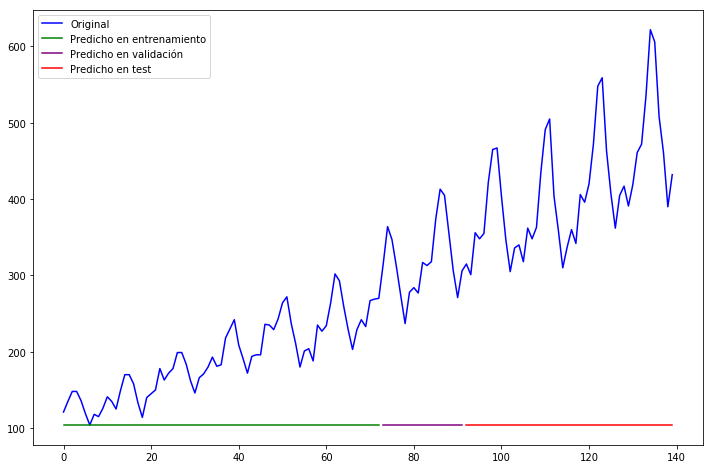

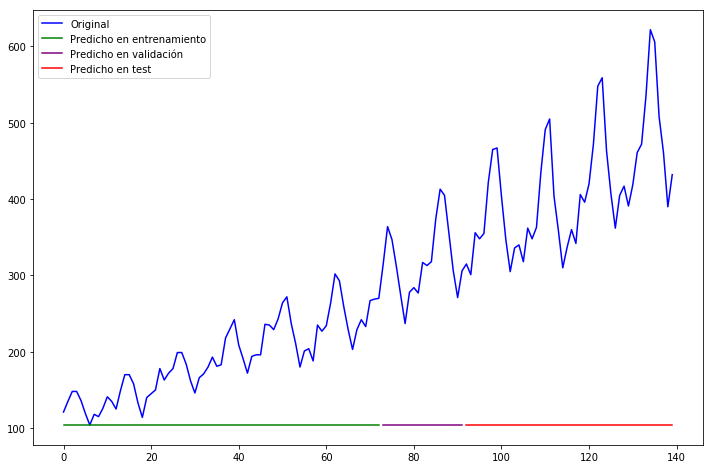

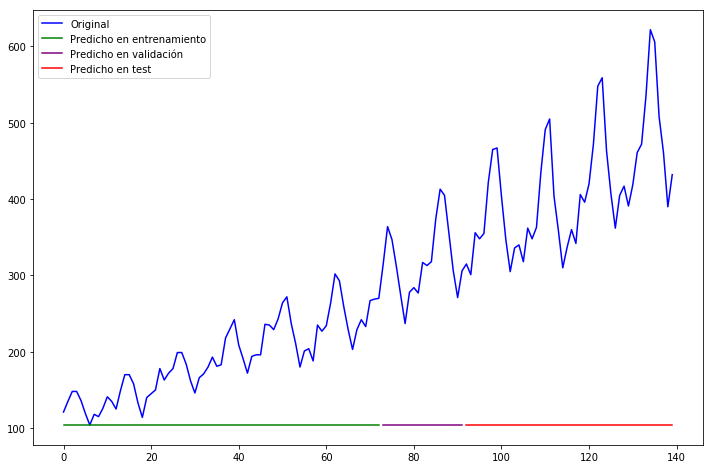

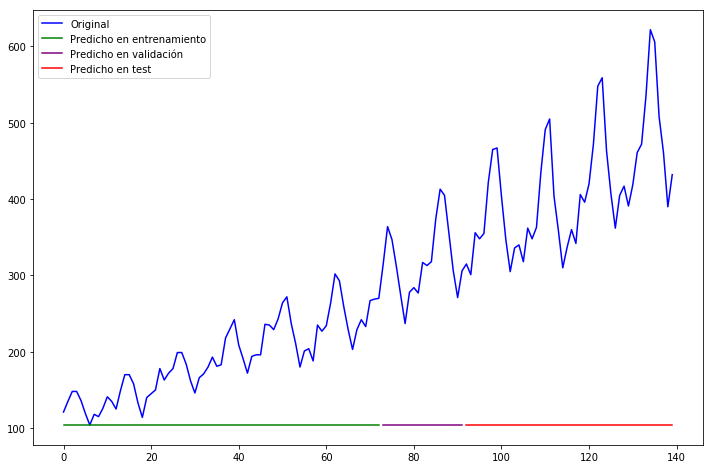

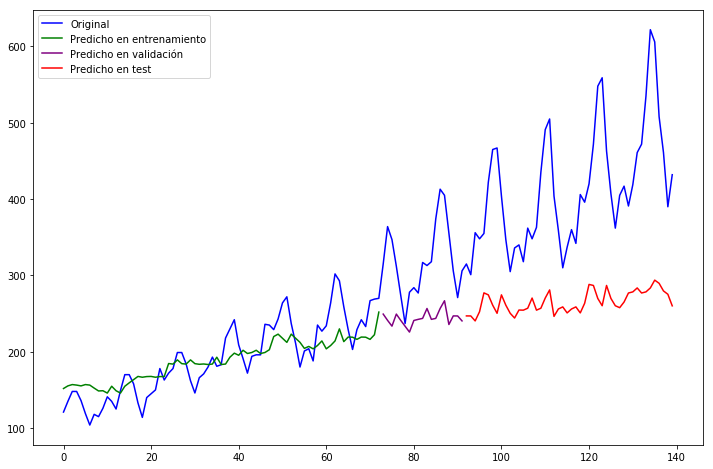

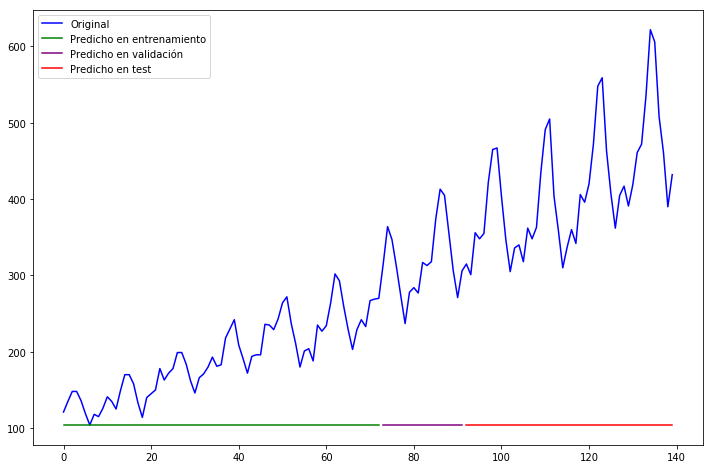

In [164]:
INPUT_DIM = 1
HIDDEN_DIM = 5
NUM_LAYERS = 1

HISTORY_LENGTH = 4

EPOCHS = 1000
BATCH_SIZE = 8


NUM_EXPERIMENTS = 10
list_rmse = []

for i in range(NUM_EXPERIMENTS):
 
  print("EXPERIMENTO Nº: {}".format(i))
  test_rmse = main(LSTM, HISTORY_LENGTH, EPOCHS, BATCH_SIZE, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, batch_size=BATCH_SIZE)
  list_rmse.append(test_rmse)

**Segundo Experimento**

Aqui se aumenta el tamaño del Hidden Size a 20. En esta configuración se logró registrar, despues de probar varias, algo de aprendizaje por parte del LSTM.

SIn embargo, este sigue siendo deficiente en comparación a los casos anteriores. Al realizar solamente una instancia del experimento, se ve que se alcanza un RMSE de 178. En el gráfico se ve quye algo de la forma dela curva es aprendido (estacionalidad), pero la tendencia se mantiene plana, lo cual no corresponde a la realidad. Esto indica una vez más que el ajuste es malo en comparación al modelo de RNN anterior que incluso con DropOut funciona mucho mejor.

EXPERIMENTO Nº: 0
Size of train/val/test:  73 19 48


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0100: loss = 0.00788; val loss = 0.02878
Epoch #0200: loss = 0.00858; val loss = 0.02618
Epoch #0300: loss = 0.00748; val loss = 0.03227
Epoch #0400: loss = 0.00749; val loss = 0.03630
Epoch #0500: loss = 0.00740; val loss = 0.02419
Epoch #0600: loss = 0.00855; val loss = 0.02142
Epoch #0700: loss = 0.00789; val loss = 0.02619
Epoch #0800: loss = 0.00829; val loss = 0.03238
Epoch #0900: loss = 0.00836; val loss = 0.02264
Epoch #1000: loss = 0.00752; val loss = 0.02830
Test RMSE:  178.20724493379166


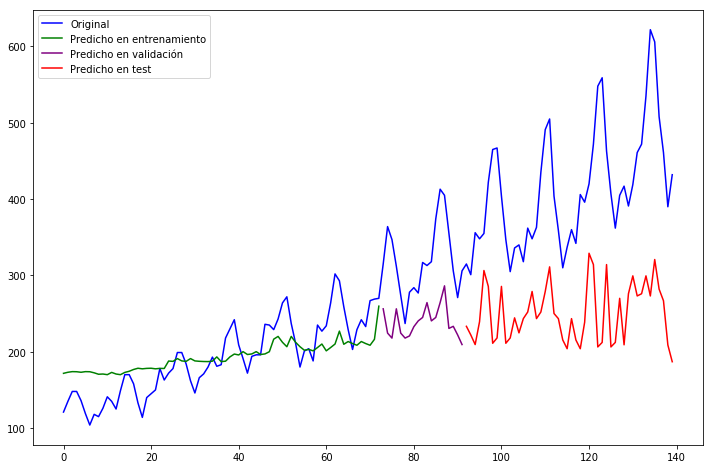

In [0]:
INPUT_DIM = 1
HIDDEN_DIM = 20
NUM_LAYERS = 1

HISTORY_LENGTH = 4

EPOCHS = 1000
BATCH_SIZE = 8


NUM_EXPERIMENTS = 1
list_rmse = []

for i in range(NUM_EXPERIMENTS):
 
  print("EXPERIMENTO Nº: {}".format(i))
  test_rmse = main(LSTM, HISTORY_LENGTH, EPOCHS, BATCH_SIZE, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, batch_size=BATCH_SIZE)
  list_rmse.append(test_rmse)

Se concluye que el desempeño de la LSTM es peor al de la red RNN inicial, pues posee mayor RSME, y este a su vez posee mayor varianza. Al analizar los gráficos, estos evidencian que efectivamente el ajuste es malo.

In [141]:
input_dim = 1
hidden_dim = 5
num_layers = 1


model = RNN(input_dim, hidden_dim, num_layers)
params = num_trainable_parameters(model)
print("Cantidad de Parametros: {}".format(params))

Cantidad de Parametros: 46


In [142]:
input_dim = 1
hidden_dim = 5
num_layers = 1


model = LSTM(input_dim, hidden_dim, num_layers)
params = num_trainable_parameters(model)
print("Cantidad de Parametros: {}".format(params))

Cantidad de Parametros: 406


En términos de los parámetros de cada una, osbervamos que el modelo LSTM con los mismos parámetros dimensionales de entrada, tiene aproximadamente 9 veces más parámetros que la red RNN original. Esto es evidencia de que un modelo mucho más complejo no necesariamente es mejor para predecir una serie de tiempo simple, sobre todo si tiene pocos datos.


# 2. Neural Machine Translation

## 2.0 Preliminares

A continuación se realizan algunos preliminares:

1. Se instalan librerías necesarias.
2. Se instalan dependencias.
3. Se monta el disco de Google Drive.
4. Se desencriptan los datos.
5. Se define la GPU.

In [1]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip

     / 737kB 1.6MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-avhjbf_1/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
import os
import time
import json
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from google.colab import drive
from torch.utils.data import Dataset, Subset, DataLoader
from tqdm import tqdm_notebook as tqdmn
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
import scipy.signal


In [78]:
plt.rcParams['figure.figsize'] = [10, 6]

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path = '/content/gdrive/My Drive/Universidad/Universidad/7mo año/1er Semestre/Deep Learning/Tareas/Tarea 3'
os.chdir(path)

In [7]:
!tar -C /content -zxvf en_es_data.tar.gz 

./._en_es_data
en_es_data/
en_es_data/._dev.en
en_es_data/dev.en
en_es_data/._dev.es
en_es_data/dev.es
en_es_data/._train.es
en_es_data/train.es
en_es_data/._train.en
en_es_data/train.en
en_es_data/._test.es
en_es_data/test.es
en_es_data/._test.en
en_es_data/test.en


In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


## 2.1 Actividad 4

### 2.1.1 Datasets y Data Loaders

Las siguientes clases permiten cargar los datos en **DataLoaders** de Entrenamiento, Validación y Testeo.

In [0]:
from itertools import chain
from collections import Counter

FREQUENCY_THRESHOLD = 2
VOCAB_SIZE = 50000

class CorpusDataset(torch.utils.data.Dataset):

    
    
    def __init__(self, path, src, dst, src_token2id=None, src_id2token=None, dst_token2id=None, dst_id2token=None):
        assert src in ("es", "en")
        assert dst != src and dst in ("es", "en")
        
        self.PAD_TOKEN = "<pad>"
        self.START_TOKEN = "<s>"
        self.END_TOKEN = "</s>"
        self.UNKNOWN_TOKEN = "<unk>"
        
        self.src_sentences = self._load_sentences(path, src)
        self.dst_sentences = self._load_sentences(path, dst)
        assert len(self.src_sentences) == len(self.dst_sentences)
        
        if src_token2id is None and src_id2token is None and dst_token2id is None and dst_id2token is None:
            self.src_token2id, self.src_id2token = self._build_token2id(self.src_sentences)
            self.dst_token2id, self.dst_id2token = self._build_token2id(self.dst_sentences)
        else:
            self.src_token2id, self.src_id2token = src_token2id, src_id2token
            self.dst_token2id, self.dst_id2token = dst_token2id, dst_id2token
    
    def _load_sentences(self, path, lang):
        path = path + f".{lang}"
        with open(path, "r") as corpus_file:
            sentences = [line.lower().strip().split(" ") for line in corpus_file]
        return sentences
    
    def _build_token2id(self, sentences):
        id2token = {0:self.PAD_TOKEN, 1:self.START_TOKEN, 2:self.END_TOKEN, 3:self.UNKNOWN_TOKEN}
        token2id = {self.PAD_TOKEN:0, self.START_TOKEN:1, self.END_TOKEN:2, self.UNKNOWN_TOKEN:3}

   
        frequencies = Counter(chain.from_iterable(sentences)).most_common(VOCAB_SIZE)
        
        it = 0
        for word, count in frequencies:         
          if count >= FREQUENCY_THRESHOLD:    
            id2token[it+4] = word
            token2id[word] = it+4
            it+=1
            
        return token2id, id2token


    def _tokens2ids(self, token2id, tokens, is_target=False):
        ids = []
        for token in tokens:
            if token in token2id:
                ids.append(token2id[token])
            else:
                ids.append(token2id[self.UNKNOWN_TOKEN])
        if is_target:
            ids.insert(0, token2id[self.START_TOKEN])
            ids.append(token2id[self.END_TOKEN])
        return ids
    
    def __getitem__(self, idx):
        src_tokens, dst_tokens = self.src_sentences[idx], self.dst_sentences[idx]
        src_ids, dst_ids = self._tokens2ids(self.src_token2id, src_tokens), self._tokens2ids(self.dst_token2id, dst_tokens, is_target=True)
        return {
            "src": src_ids,
            "dst": dst_ids
        }
    
    def __len__(self):
        return len(self.src_sentences)
    
    def ids2tokens(self, id2token, ids):
        tokens = [id2token[id] for id in ids]
        return " ".join(tokens)

TRAIN_PATH = "/content/en_es_data/train"
TEST_PATH = "/content/en_es_data/test"
DEV_PATH = "/content/en_es_data/dev"

train_dataset = CorpusDataset(
    path=TRAIN_PATH,
    src="en",
    dst="es")
dev_dataset = CorpusDataset(
    path=DEV_PATH,
    src="en",
    dst="es",
    src_token2id=train_dataset.src_token2id,
    src_id2token=train_dataset.src_id2token,
    dst_token2id=train_dataset.dst_token2id,
    dst_id2token=train_dataset.dst_id2token)
test_dataset = CorpusDataset(
    path=TEST_PATH,
    src="en",
    dst="es",
    src_token2id=train_dataset.src_token2id,
    src_id2token=train_dataset.src_id2token,
    dst_token2id=train_dataset.dst_token2id,
    dst_id2token=train_dataset.dst_id2token)

BATCH_SIZE = 32

def collate_sentences(batch):
    """
    Esta función permite construir lotes de pares de oraciones en lenguaje de origen y objetivo.
    Al utilizar secuencias, en este caso oraciones, de largo variable en redes recurrentes es necesario
    empaquetarlas para hacer cálculos eficientes en PyTorch. En esta tarea particular, solo se
    necesita empaquetar las oraciones de entrada. Para empaquetar secuencias, es requisito que estén
    ordenadas de acuerdo a su largo en forma decreciente.
    
    Si se desea profundizar:
        https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence
        https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
    """
    src = []
    dst = []
    for item in batch:
        src.append(torch.tensor(item["src"]))
        dst.append(torch.tensor(item["dst"]))
    src_dst_zipped = list(zip(src, dst))
    src_dst_zipped.sort(key=lambda x: len(x[0]), reverse=True)
    
    batch_dict = {
        "src": [],
        "dst": [],
        "src_lengths": [],
        "dst_lengths": []
    }
    
    for pair in src_dst_zipped:
        batch_dict["src"].append(pair[0])
        batch_dict["src_lengths"].append(len(pair[0]))
        batch_dict["dst"].append(pair[1])
        batch_dict["dst_lengths"].append(len(pair[1]))
        
    
    for elem in ("src", "dst"):
        lengths_name = f"{elem}_lengths"
        batch_dict[lengths_name] = torch.tensor(batch_dict[lengths_name])
        batch_dict[elem] = nn.utils.rnn.pad_sequence(
            sequences=batch_dict[elem],
            batch_first=True,
            padding_value=0)
        
    return batch_dict

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_sentences)

dev_dataloader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_sentences)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_sentences)


### 2.1.2 Encoder

A continuación se presenta la implementación del **Encoder**. La implementación de esta clase se basa en [1] y [2].



In [0]:
class _EncoderModule(nn.Module):
    def __init__(self, embeddings_table, embeddings_size, hidden_size):
        super().__init__()
        
        # Se inicializa el embedding table, el embedding size, el hidden size y la LSTM
        self.embeddings_table = embeddings_table
        self.embeddings_size = embeddings_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=self.embeddings_size, hidden_size=self.hidden_size, bias=True, bidirectional=True)
               
    def forward(self, src_sentences, src_lengths):
      
       
        # Se generan los Embeddings
        embedded = self.embeddings_table(src_sentences)
        
        # Se transpone para mantener el shape pedido
        embedded.transpose_(1,0) 
        
        # Se genera el pack para las sentencias
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_lengths)
        
        # Se aplica la capa LSTM y se guarda el resultado que viene en forma de pack
        packed_outputs, (all_hidden_states, all_cell_states) = self.lstm(packed_embedded)   
        
        # Se realiza un pad
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
        
        # Se transpone para conservar las dimensiones de output deseadas        
        outputs.transpose_(1,0)
        
                       
        return outputs, all_hidden_states, all_cell_states


###  2.1.3 Decoder

A continuación se implementa el **Decoder** del modelo. La implementación de esta clase está basada en [1] y [2].

Se hizo un esfuerzo computacional por prioirzar operaciones in-place, ya que mal controlado, esta clase puede terminar por utilizar toda la ram rápidamente.

In [0]:
class _DecoderModule(nn.Module):
  
    def __init__(
            self,
            embeddings_table,
            embeddings_size,
            hidden_size,
            start_idx,
            dropout_prob,
            dst_vocab_size
        ):
        super().__init__()
        
        # Se inicializa:
        # Embedding Table, Embedding Size, Hidden Size, Start Idx y Vocab Size de destino
        self.embeddings_table = embeddings_table
        self.embeddings_size = embeddings_size
        self.hidden_size = hidden_size
        self.start_idx = torch.tensor(start_idx).to(DEVICE)
        self.dst_vocab_size = dst_vocab_size
        
        # Se initializan todas las capas a ser ejecutadas, en conjunto con sus dimensiones
        self.W_h = nn.Linear(2*self.hidden_size, self.hidden_size, bias=False)
        self.W_c = nn.Linear(2*self.hidden_size, self.hidden_size, bias=False)
        self.lstm_cell = nn.LSTMCell(self.hidden_size+self.embeddings_size, self.hidden_size)
        self.W_attn = nn.Linear(2*self.hidden_size, self.hidden_size, bias=False)
        self.W_u = nn.Linear(3*self.hidden_size, self.hidden_size, bias=False)
        self.dropout = nn.Dropout(dropout_prob)
        self.W_vocab = nn.Linear(self.hidden_size, self.dst_vocab_size, bias=False)

    
    def init_hidden_cell(self, final_enc_hidden_states, final_enc_cell_states, batch_size):
      
        # Esta funcion inicializa o_0, y_0, h^dec_0, c^dec_0
        hidden_dec = torch.squeeze(torch.cat((final_enc_hidden_states[-2,:,:], final_enc_hidden_states[-1,:,:]), dim = 1))
        cell_dec = torch.squeeze(torch.cat((final_enc_cell_states[-2,:,:], final_enc_cell_states[-1,:,:]), dim = 1))
        hidden_dec = self.W_h(hidden_dec)
        cell_dec = self.W_c(cell_dec)
        y_t = self.embeddings_table(self.start_idx.repeat(batch_size)).to(DEVICE)
        o_t = torch.zeros(batch_size, self.hidden_size).to(DEVICE)

        return hidden_dec, cell_dec, y_t, o_t
 
    def forward(self, all_enc_hidden_states, final_enc_hidden_states, final_enc_cell_states, max_sentence_length):
         
        # Se guarda el tamaño del batch
        batch_size = all_enc_hidden_states.shape[0]
        
        # Se initializan tensores para los outputs y los indices de las predicciones
        outputs = torch.zeros(batch_size, max_sentence_length, self.dst_vocab_size).to(DEVICE)
        preds = torch.zeros(batch_size, max_sentence_length).to(DEVICE)
        
        # Se inicializan: o_0, y_0, h^dec_0, c^dec_0
        hidden_dec_prev, cell_dec_prev, y_t, o_t = self.init_hidden_cell(final_enc_hidden_states, final_enc_cell_states, batch_size)

        # A continuacion, viene un loop que itera hasta el largo maximo de sentencias
        # Se realizan las operaciones mencionadas en el enunciado
        for t in range(max_sentence_length):
          
            out = torch.cat((y_t, o_t), dim=1)
            
            hidden_dec, cell_dec = self.lstm_cell(out, (hidden_dec_prev, cell_dec_prev))
            
            out = F.softmax(torch.bmm(self.W_attn(all_enc_hidden_states), hidden_dec.unsqueeze(2)), dim=1)
        
            out = out*all_enc_hidden_states

            out = torch.sum(out, dim=1)

            o_t = self.dropout(torch.tanh(self.W_u(torch.cat((out, hidden_dec), dim=1))))

            out = self.W_vocab(o_t)
            
            y_t = torch.argmax(F.softmax(out, dim=1), 1)
            
            preds[:,t] = y_t

            y_t = self.embeddings_table(y_t)

            outputs[:,t,:] = out
            
            hidden_dec_prev = hidden_dec
            
            cell_dec_prev = cell_dec

        
        return outputs, preds

### 2.1.4 Neural Machine Translator

A continuación se define la clase **NeuralMachineTranslator**. Esta clase administra la integración entre el **Encoder** y el **Decoder**, y es la clase que finalmente se utilizará para entrenar.

In [0]:
class NeuralMachineTranslator(nn.Module):
  
    def __init__(self, src_vocab_size, dst_vocab_size, start_idx, embeddings_size, hidden_size, dropout_prob):
        super().__init__()
        
        self.src_embeddings_table = nn.Embedding(num_embeddings=src_vocab_size, embedding_dim=embeddings_size, padding_idx=0)
        self.dst_embeddings_table = nn.Embedding(num_embeddings=dst_vocab_size, embedding_dim=embeddings_size, padding_idx=0)
        
        self.hidden_size = hidden_size
        
        self.encoder_module = _EncoderModule(
            embeddings_table=self.src_embeddings_table,
            embeddings_size=embeddings_size,
            hidden_size=hidden_size)
        
        self.decoder_module = _DecoderModule(
            embeddings_table=self.dst_embeddings_table,
            embeddings_size=embeddings_size,
            hidden_size=hidden_size,
            start_idx=start_idx,
            dropout_prob=dropout_prob,
            dst_vocab_size=dst_vocab_size)
     
    def forward(self, src_sentences, src_lengths, dst_lengths):
        
        # Esta clase administra el Encoder y el Decoder, dado un batch de entrada
        max_len = max(dst_lengths)
        all_hidden_states, final_enc_hidden_states, final_enc_cell_states = self.encoder_module(src_sentences.to(DEVICE), src_lengths.to(DEVICE))
        outputs, preds = self.decoder_module(all_hidden_states, final_enc_hidden_states, final_enc_cell_states, max_len)

        return outputs, preds
  
      


### 2.1.5 Conteo de Parámetros

Se aprecia que en total la Red NMT posee 40.834.048 parámetros entrenables.

In [92]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
  
EMBEDDINGS_SIZE = 256
HIDDEN_SIZE = 256
GRADIENT_CLIPPING = 5
DECAY_PATIENCE = 5
LR_DECAY = 0.5
LR = 0.001
DROPOUT_PROB = 0.3
EPOCHS = 10

nmt = NeuralMachineTranslator(
    src_vocab_size=len(train_dataset.src_token2id),
    dst_vocab_size=len(train_dataset.dst_token2id),
    start_idx = train_dataset.src_token2id[train_dataset.START_TOKEN],
    embeddings_size=EMBEDDINGS_SIZE,
    hidden_size=HIDDEN_SIZE,
    dropout_prob=DROPOUT_PROB)

print("Cantidad de Parametros: {}".format(count_parameters(nmt)))

Cantidad de Parametros: 40834048


### 2.1.6 Vocabulario

Vemos que el tamaño de los vocabularios está dado por:

In [11]:
src_vocab_size=len(train_dataset.src_token2id)
dst_vocab_size=len(train_dataset.dst_token2id)
print("Tamaño Vocabulario ORIGEN: {}".format(src_vocab_size))
print("Tamaño Vocabulario DESTINO: {}".format(dst_vocab_size))

Tamaño Vocabulario ORIGEN: 50004
Tamaño Vocabulario DESTINO: 50004


Vemos que en este caso ambos tienen el mismo tamaño.  

Si el tamaño del vocabulario aumenta, las consecuencias serían:

1. Mayor gasto de memoria en términos de la creación de tensores que guarden la distribución de probabilidades.
2. Mayor dificultad para que un embedding de tamaño fijo pueda almacenar toda la información del vocabulario, con lo cual el espacio intermedio de dimension finita tendrá mayor discrepancia con ambos idiomas.
3. Eventualmente, mayor dificultad para aprender debido al motivo anterior, con lo cual se requerirá un mayor número de épocas.

## 2.2 Actividad 5

### 2.2.1 Funciones de Entrenamiento

En este apartado se definen las funciones de entrenamiento. Además, se crean carpetas para guardar los resultados.

In [12]:
! mkdir outputs
! mkdir checkpoints
! mkdir outputs_retrain
! mkdir checkpoints_retrain

mkdir: cannot create directory ‘outputs’: File exists
mkdir: cannot create directory ‘checkpoints’: File exists
mkdir: cannot create directory ‘outputs_retrain’: File exists
mkdir: cannot create directory ‘checkpoints_retrain’: File exists


A continuación se definen las funciones relevantes:

1. **train**: Realiza el entrenamiento del modelo, iterando sobre los batch disponibles en el dataloader. Esta función está basada en la función de entrenamiento disponible en [1] y [2].
2. **evaluate**: Realiza la evaluación del modelo sobre algún conjunto de testeo o validación. También basada en [1] y [2].

La idea de poner los iteradores con estilo *tdqm* fue conversada con compañeros del curso, y es solamente para embellecer la presentación de resultados y evitar perder los outputs.

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0  
    epoch_acc = 0
    
    outputs = {}
    
    
    for i, batch in enumerate(tqdmn(iterator, desc="Train", leave=False, mininterval=2)):
      
        #if i>-1:
        #  break
      
        src = batch['src'].to(DEVICE)
        dst = batch['dst'].to(DEVICE)
        src_lengths = batch['src_lengths'].to(DEVICE)
        dst_lengths = batch['dst_lengths'].to(DEVICE)

        optimizer.zero_grad()

        output, preds = model(src, src_lengths, dst_lengths)
      
        loss = criterion(output.view(-1, output.size(2)), dst.view(-1))
       
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()
        
        outputs[i] = {'pred': preds , 'targets': dst, 'batch_loss':loss.item()}  
        
    return (epoch_loss / len(iterator), epoch_acc / len(iterator), outputs)

def epoch_time(start_time, end_time):
  
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
  
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    epoch_acc = 0
    
    outputs = {}
    
    with torch.no_grad():
    
        for i, batch in enumerate(tqdmn(iterator, desc="Val", leave=False, mininterval=2)):
        
          src = batch['src'].to(DEVICE)
          dst = batch['dst'].to(DEVICE)
          src_lengths = batch['src_lengths'].to(DEVICE)
          dst_lengths = batch['dst_lengths'].to(DEVICE)

          output, preds = model(src, src_lengths, dst_lengths) 
          #print(output.shape)
                   
          loss = criterion(output.view(-1, output.size(2)), dst.view(-1))

          epoch_loss += loss.item()
          
          outputs[i] = {'pred': preds , 'targets': dst, 'batch_loss':loss.item()}
        
    return (epoch_loss / len(iterator), epoch_acc / len(iterator), outputs)
  

### 2.2.2 Funciones de Experimentos

A continuación se presentan las funciones con las cuales se realiza la experimentación:

1. **experiment**: Esta función recibe un estado del modelo, el optimizador y la función de pérdida. Esta función administra la ejecución del entrenamiento y validación, el guardado de resultados y las épocas en las cuales se debe iterar.
2. **load_model**: Esta función permite cargar un modelo y optimizador guardados previamente.

In [0]:
def experiment(modelo, optim, loss, gradient_cliping, path_output, path_checkpoints, epoch_inicial, epoch_final):
  
  best_valid_loss = float('inf')
  history = {}

  counter_valid = 0
  valid_loss_prev = 0
  
  for epoch in tqdmn(range(epoch_inicial, epoch_final), desc="Epocas", leave=False, mininterval=2):

    start_time = time.time()
    
    train_loss, train_acc, train_outputs = train(modelo, train_dataloader, optim, loss, gradient_cliping)
    valid_loss, valid_acc, val_outputs = evaluate(modelo, dev_dataloader, loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
   

    if epoch >=1:
      if valid_loss <= valid_loss_prev:
        counter_valid += 1 
      else:
        counter_valid = 0
      
    if counter_valid >= DECAY_PATIENCE:
      for g in optimizer.param_groups:
        g['lr'] = g['lr']*LR_DECAY
        
    history[epoch] = {'train_loss': train_loss, 'valid_loss': valid_loss, 'train_acc': train_acc, 'valid_acc': valid_acc, 'epoch_mins':epoch_mins}
    
    torch.save({'train_outputs':train_outputs,
               'val_outputs':val_outputs}, path_output.format(epoch))
    
    torch.save({'model_state_dict': nmt.state_dict(),
                'optim_state_dict': optimizer.state_dict(),
                'history':history}, path_checkpoints.format(epoch))

    valid_loss_prev = valid_loss
    
    
def load_model(model, optim, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optim_state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = True

    return (model, optim)

### 2.2.3 Ejecucion de Experimentos: Entrenamiento y Validación

A continuación se define el modelo a entrenar con los parámetros entregados en el enunciado de la Tarea.

In [0]:
EMBEDDINGS_SIZE = 256
HIDDEN_SIZE = 256
GRADIENT_CLIPPING = 5
DECAY_PATIENCE = 5
LR_DECAY = 0.5
LR = 0.001
DROPOUT_PROB = 0.3
EPOCHS = 50

nmt = NeuralMachineTranslator(
    src_vocab_size=len(train_dataset.src_token2id),
    dst_vocab_size=len(train_dataset.dst_token2id),
    start_idx = train_dataset.src_token2id[train_dataset.START_TOKEN],
    embeddings_size=EMBEDDINGS_SIZE,
    hidden_size=HIDDEN_SIZE,
    dropout_prob=DROPOUT_PROB)

nmt.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nmt.parameters(), lr=LR)

Luego, comienza el entrenamiento. Se definen los destintos para el guardado de los resultados intermedios. En esta implementación, se decidió omitir el calculo del BLEU para después. Esto debido a que las implementaciones actuales no permiten el uso de tensores de manera directa, con lo cual la ejecución de esta métrica aportará un considerable costo por iteración si no se implementa bien.  COn lo cual, se decidió guardar todas las predicciones para cada batch de la ejecución. A continuación se muestra una foto de cómo se ven estos archivos :

![Checkpoints](https://drive.google.com/uc?id=1rMzegQvf_yFNJpx7WJHmX5R3qTmZ7RED)

![Outputs](https://drive.google.com/uc?id=1rPVFqG5Pzvb28awhXQ75PNouGX8F3u4o)



A continuación, se ve que se alcanzó a ejecutar 6 épocas. Luego el código se detuvo debido a que google Colab Finalizó la sesión.

In [0]:
path_checkpoints = 'checkpoints_retrain/t3p2_chechpoint_epch_{}.pkl'
path_outputs = 'outputs_retrain/t3p2_output_epch_{}.pkl'

path_load_model = 'checkpoints/t3p2_chechpoint_epch_3.pkl'

#nmt, optimizer = load_model(nmt, optimizer, path_load_model)

epoch_inicial = 0
epoch_final = EPOCHS

experiment(nmt, optimizer, criterion, GRADIENT_CLIPPING, path_outputs, path_checkpoints, epoch_inicial, epoch_final)

Posteriormente, se continuó el entrenamiento cargando el modelo guardado en la última época anterior.


Nota: Esto se repitió varias veces, per osolamente se alcanzo a entrenar un total de 17 épocas sin errores de implementación.

In [0]:
path_checkpoints = 'checkpoints_retrain/t3p2_chechpoint_epch_{}.pkl'
path_outputs = 'outputs_retrain/t3p2_output_epch_{}.pkl'

path_load_model = 'checkpoints_retrain/t3p2_chechpoint_epch_5.pkl'

nmt, optimizer = load_model(nmt, optimizer, path_load_model)

epoch_inicial = 6
epoch_final = EPOCHS

experiment(nmt, optimizer, criterion, GRADIENT_CLIPPING, path_outputs, path_checkpoints, epoch_inicial, epoch_final)

/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm_notebook.py:88: TqdmExperimentalWarning: Detect Google Colab 0.0.1a2 and thus load dummy ipywidgets package. Note that UI is different from that in Jupyter. See https://github.com/tqdm/tqdm/pull/640
  " See https://github.com/tqdm/tqdm/pull/640".format(colab.__version__), TqdmExperimentalWarning)


### 2.2.4 Gráficos: Función de Pérdida

A continuación se implementan algunas funciones que permiten leer los archivos guardados y mostrar gráficos de la función de pérdida de Entrenamiento y Validación.

In [0]:
def load_outputs(paths):
    
    train_outputs_ = []
    train_losses_ = []
    
    val_outputs_ = []
    val_losses_ = []
    
    for path in paths:
        output = torch.load(path, map_location='cpu')
        
        #print(output['train_outputs'].keys())
        train_outputs, train_losses = recover_epoch_data(output['train_outputs'])
        val_outputs, val_losses = recover_epoch_data(output['val_outputs'])
        
        val_losses_ +=(val_losses)
        val_outputs_ +=(val_outputs)
        
        train_losses_ +=(train_losses)
        train_outputs_ +=(train_outputs)
            
    return (train_outputs_, train_losses_, val_outputs_, val_losses_)

def recover_epoch_data(output):
    
    losses = []
    outputs = []
    for batch in output.keys():
        #print(batch, output[batch])
        #print(output[batch].keys())
        #preds, target, loss = output[batch]['pred'], output[batch]['targets'], output[batch]['batch_loss']
        preds, target, loss = output[batch]['pred'], output[batch]['targets'], output[batch]['batch_loss']
        
        losses.append(loss)
        outputs.append((preds, target))
        
    return (outputs, losses)

In [0]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [0]:
paths = ['outputs_retrain/t3p2_output_epch_{}.pkl'.format(i) for i in range(0,17)]

N_train = len(train_dataloader)
N_val = len(dev_dataloader)

train_outputs, train_losses, val_outputs, val_losses = load_outputs(paths)



Gráficos de la Función de  Pérdida  como función del Batch para Entrenamiento y Validación.

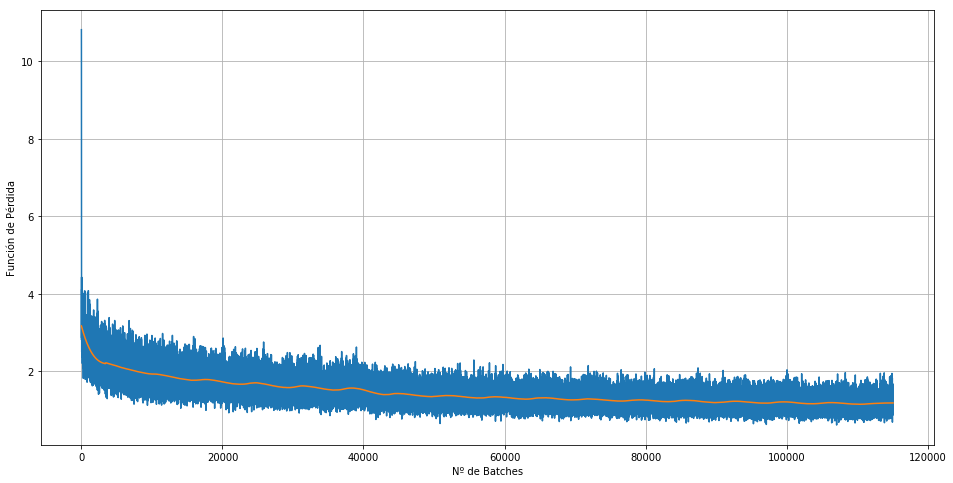

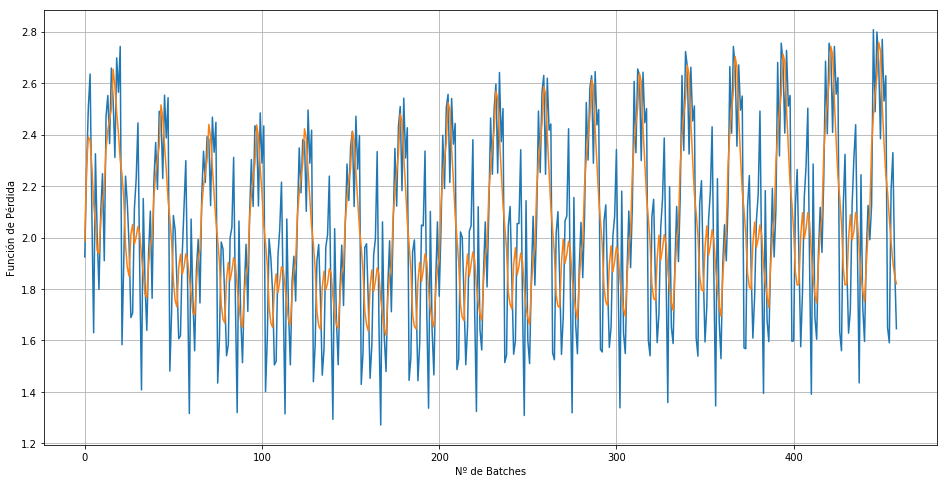

In [24]:
import scipy.signal

fig = plt.figure()
plt.plot(train_losses)
plt.plot(scipy.signal.savgol_filter(train_losses,  N_train+1, 3))
plt.xlabel('Nº de Batches')
plt.ylabel('Función de Pérdida')
plt.grid(True)
plt.show()


fig = plt.figure()
plt.plot(val_losses)
plt.plot(scipy.signal.savgol_filter(val_losses,  11, 3))
plt.xlabel('Nº de Batches')
plt.ylabel('Función de Pérdida')
plt.grid(True)
plt.show()




Graficos de Función de Pérdida como Función de la Época para Entrenamiento y Validación

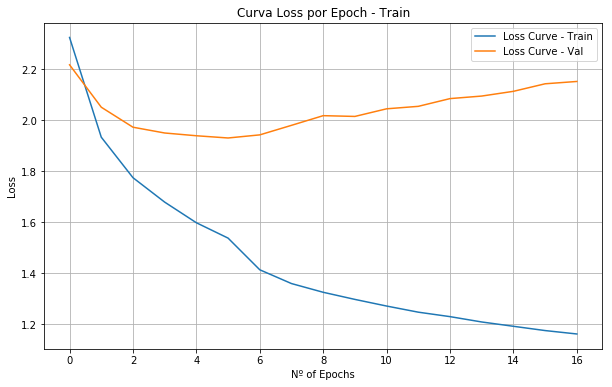

In [111]:
epoch_losses_train = [np.mean(train_losses[N_train*i:N_train*(i+1)]) for i in range(17)]

fig = plt.figure()
plt.plot(epoch_losses_train, label='Loss Curve - Train')
#plt.plot(scipy.signal.savgol_filter(bleu_scores_val, N_val, 3))
#plt.plot(movingaverage(bleu_scores_train, N_train), label='Averaged Curve')
plt.xlabel('Nº of Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.title('Curva Loss por Epoch - Train')
#plt.show()


epoch_losses_val = [np.mean(val_losses[N_val*i:N_val*(i+1)]) for i in range(17)]

#fig = plt.figure()
plt.plot(epoch_losses_val, label='Loss Curve - Val')
#plt.plot(scipy.signal.savgol_filter(bleu_scores_val, N_val, 3))
#plt.plot(movingaverage(bleu_scores_train, N_train), label='Averaged Curve')
#plt.xlabel('Nº of Epochs')
#plt.ylabel('Loss')
plt.grid(True)
plt.legend()
#plt.title('Curva Loss por Epoch - Validacion')
plt.show()

In [0]:
tiempo = np.linspace(0, (len(paths)*60), num=len(losses))
fig = plt.figure()
plt.plot(tiempo, losses)
plt.plot(tiempo, scipy.signal.savgol_filter(losses, N+1, 3))
plt.xlabel('Tiempo de Entrenamiento (min)')
plt.ylabel('Función de Pérdida')
plt.grid(True)
plt.show()

### 2.2.5 Gráficos: Bleu score

A continuación se implementa una función que calcula el Bleu score para todas las predicciones realizadas.



In [0]:
def bleu_score(outputs, dataset):
    
    id2token = np.vectorize(dataset.dst_id2token.__getitem__)
    bloqued = ["<pad>", "<s>", "</s>", "<unk>"]
    smooth = SmoothingFunction()
    
    counter = 0
 
    bleu_scores = []
    for i, (preds, targets) in enumerate(outputs):
        #if  counter >1:
        #    break
        preds_sentences = [ [i for i in sentence  if i not in bloqued]  for sentence in id2token(preds) ]
        target_sentences = [ [i for i in sentence if i not in bloqued]  for sentence in id2token(targets) ]
        
        #for j in range(len(preds_sentences)):
        #    print("Nueva Prediccion")
        #    print(preds_sentences[j])
        #    print("Nueva Target")
        #    print(target_sentences[j])
        #    print("___________________")
        #print(preds_sentences)
        #print(target_sentences)
        bleu= [sentence_bleu([pred], target, smoothing_function=smooth.method0) for pred, target in zip(preds_sentences, target_sentences)]
        #print(np.mean(bleu_scores))
        #counter+=1
        
        bleu_scores.append(np.mean(bleu))
        #print(np.mean(bleu))
        
    return bleu_scores

In [95]:
bleu_scores_train = bleu_score(train_outputs, train_dataset)      


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


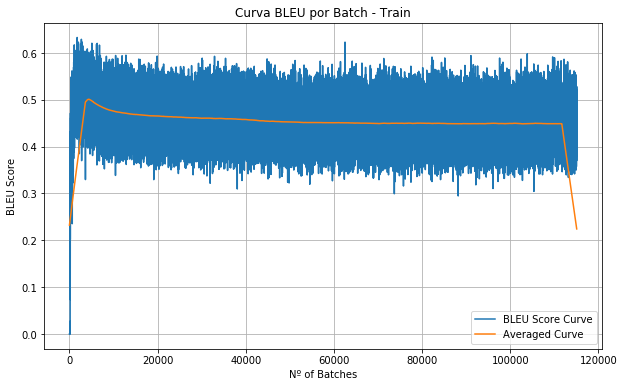

In [97]:
fig = plt.figure()
plt.plot(bleu_scores_train, label='BLEU Score Curve')
#plt.plot(scipy.signal.savgol_filter(bleu_scores_val, N_val, 3))
plt.plot(movingaverage(bleu_scores_train, N_train), label='Averaged Curve')
plt.xlabel('Nº of Batches')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.legend()
plt.title('Curva BLEU por Batch - Train')
plt.show()

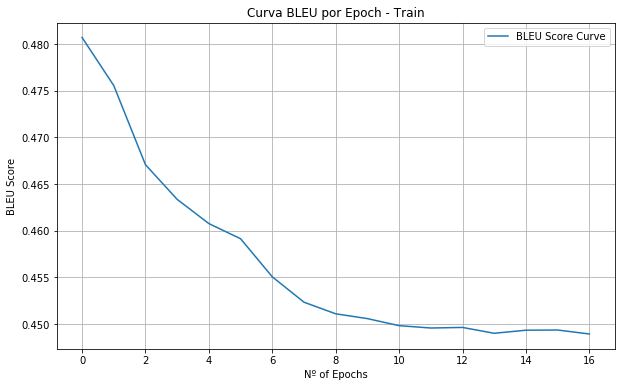

In [112]:
epoch_bleu_scores_train = [np.mean(bleu_scores_train[N_train*i:N_train*(i+1)]) for i in range(17)]

fig = plt.figure()
plt.plot(epoch_bleu_scores_train, label='BLEU Score Curve')
#plt.plot(scipy.signal.savgol_filter(bleu_scores_val, N_val, 3))
#plt.plot(movingaverage(bleu_scores_train, N_train), label='Averaged Curve')
plt.xlabel('Nº of Epochs')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.legend()
plt.title('Curva BLEU por Epoch - Train')
plt.show()


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


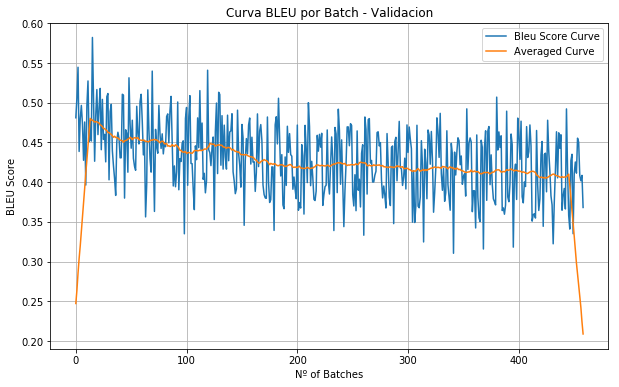

In [94]:
bleu_scores_val = bleu_score(val_outputs, dev_dataset)      


fig = plt.figure()
plt.plot(bleu_scores_val, label='Bleu Score Curve')
#plt.plot(scipy.signal.savgol_filter(bleu_scores_val, N_val, 3))
plt.plot(movingaverage(bleu_scores_val, N_val), label='Averaged Curve')
plt.xlabel('Nº of Batches')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.legend()
plt.title('Curva BLEU por Batch - Validacion')
plt.show()

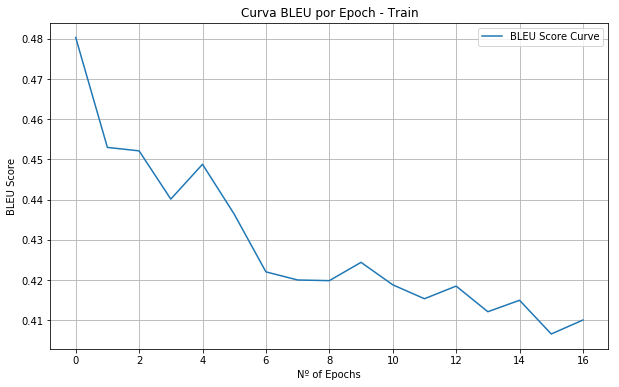

In [108]:
epoch_bleu_scores_val = [np.mean(bleu_scores_val[N_val*i:N_val*(i+1)]) for i in range(17)]

fig = plt.figure()
plt.plot(epoch_bleu_scores_val, label='BLEU Score Curve')
#plt.plot(scipy.signal.savgol_filter(bleu_scores_val, N_val, 3))
#plt.plot(movingaverage(bleu_scores_train, N_train), label='Averaged Curve')
plt.xlabel('Nº of Epochs')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.legend()
plt.title('Curva BLEU por Epoch - Train')
plt.show()

### 2.2.6 Comentarios

Se puede observar en los gráficos y en la implementación que:

1. EL costo de entrenamiento es bastante alto para lo que se está acostumbrado: el costo de una época de entrenamiento es aproximadamente de una hora.
2. En los gráficos de la sección 2.2.4 (Función de Pérdida) se puede observar a nivel de Épocas, que en el caso del entrenamiento la función de pérdida decrece, mientras que la función de pérdida en la validación decrece un poco al inicio, para luego comenzar a crecer y aumentar el gap. Esto es señal de overfitting.
3. En los gráficos de la sección 2.2.4 (Función de Pérdida) se puede observar a nivel de Batch: cierta estabilización en la pérdida a nivel de entrenamiento. Esto podría indicar que al entrenar durante otras 50 épocas podría no mejorar sustancialmente el desempeño de la red, sobre todo pensando que existe overfitting.
4. En los gráficos de la sección 2.2.5 (BLEU score) se puede observar a nivel de Épocas que hay una tendencia a la baja, pero no es claro que esto sea para siempre: la métrica podría comenzar a aumentar si se entrena durante más épocas. SIn embargo, es sorprendente que alcance un nivel entorno al 40% con tokens que no son perfectamente limpios.

## 2.3 Actividad 6

### 2.3.1 Ejecución: Set de Test

A continuación se evalúa sonre el conjunto de test. Para ello, se carga el modelo en la última etapa de entrenamiento.

In [0]:
# TO DO: CARGAR MODELO


path_load_model = 'checkpoints_retrain/t3p2_chechpoint_epch_16.pkl'

nmt, optimizer = load_model(nmt, optimizer, path_load_model)


In [53]:
test_loss, test_acc, test_outputs = evaluate(nmt, test_dataloader, criterion)

Se calcula la pérdida de test. Se ve que es en torno a 2, lo cual revela overfitting, al ser superior a los valores de entrenamiento.

In [113]:
print(test_loss)

2.0200425007986644


Se procesan los resultados para poder calcular el Bleu Score.

In [0]:
test_outputs_recovered, test_losses_recovered = recover_epoch_data(test_outputs)

Se define una nueva función para calcular el Bleu score, esta función muestra algunas frases interesantes

In [0]:
def bleu_score_interesante(outputs, dataset):
    
    id2token = np.vectorize(dataset.dst_id2token.__getitem__)
    bloqued = ["<pad>", "<s>", "</s>", "<unk>"]
    smooth = SmoothingFunction()
    
    counter = 0
 
    bleu_scores = []
    bleu_pairs = []
    for i, (preds, targets) in enumerate(outputs):

        preds_sentences = [ [i for i in sentence  if i not in bloqued]  for sentence in id2token(preds.cpu()) ]
        target_sentences = [ [i for i in sentence if i not in bloqued]  for sentence in id2token(targets.cpu()) ]
        
        if  counter <2:
          for j in range(len(preds_sentences)):            
              print("Nueva Prediccion")
              print(preds_sentences[j])
              print("Nueva Target")
              print(target_sentences[j])
              print("___________________")
              print("___________________")

        bleu = [sentence_bleu([pred], target, smoothing_function=smooth.method0) for pred, target in zip(preds_sentences, target_sentences)]
        bleu_pair = [ (sentence_bleu([pred], target, smoothing_function=smooth.method0), pred, target) for pred, target in zip(preds_sentences, target_sentences)]

        counter+=1
        
        bleu_scores.append(np.mean(bleu))
        bleu_pairs += bleu_pair

        
    return bleu_scores, bleu_pairs

In [116]:
N_test = len(test_dataloader)
bleu_scores_test, bleu_pairs_test = bleu_score_interesante(test_outputs_recovered, test_dataset)      


Nueva Prediccion
['tena', 'un', 'un', '85', '', '', 'termin', 'termin', 'en', 'san', 'san', 'california,', '--', '', 'un', 'un', 'un', 'un', '', 'y', 'en', 'los', 'los', 'los', 'los', 'que', '', '', 'empezar', 'trabajar', 'trabajar', 'trabajar', 'de', 'de', 'sida.', 'sida.']
Nueva Target
['tena', 'un', 'pulgar,', 'y', '85', 'dlares,', 'y', 'termin', 'en', 'san', 'francisco,', 'california', '--', 'encontr', 'un', 'amante', '--', 'y', 'en', 'los', 'aos', 'sent', 'la', 'necesidad', 'de', 'comenzar', 'a', 'trabajar', 'en', 'organizaciones', 'que', 'luchaban', 'contra', 'el', 'sida.']
___________________
___________________
Nueva Prediccion
['y', 'como', 'como', 'la', 'que', 'que', 'quera', 'saber', 'como', 'como', 'adulta', 'adulta', 'que', 'convirti', 'una', 'una', 'caja', 'de', '', '', 'y', 'en', 'manos.', 'manos.']
Nueva Target
['y', 'as', 'como', 'la', 'mujer', 'que', 'quera', 'como', 'adulto', 'lleg', 'a', 'se', 'convirti', 'en', 'una', 'caja', 'de', 'cenizas', 'y', 'fue', 'puesta', '

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Luego, se seleccionan las 20 sentencias con mayor valor de bleu. Se observa que todas están perfectamente traducidas, y tienen en común que son frases bastante simples, de muy pocas palabras. Ejemplos son:

----------
Prediccion:
'gracias.'
Real:
'gracias.'

----------
Prediccion:
'mi', 'nombre', 'es'
Real:
'mi', 'nombre', 'es'

----------------

----------
Prediccion:
'y', 'eso', 'es', 'todo.', 'gracias.'
Real:
'y', 'eso', 'es', 'todo.', 'gracias.'

In [0]:
bleu_pairs_test.sort(key=lambda x: x[0], reverse=True)

In [131]:
for i, sentence in enumerate(bleu_pairs_test):
  if i > 20:
    break
  print("Prediccion:")
  print(sentence[1])
  print("Real:")
  print(sentence[2])
  print("----------")

Prediccion:
['es', 'algo', 'que', 'sabamos', 'cmo', 'hacer.']
Real:
['es', 'algo', 'que', 'sabamos', 'cmo', 'hacer.']
----------
Prediccion:
['gracias.']
Real:
['gracias.']
----------
Prediccion:
['gracias.']
Real:
['gracias.']
----------
Prediccion:
['gracias.']
Real:
['gracias.']
----------
Prediccion:
['muchas', 'gracias.']
Real:
['muchas', 'gracias.']
----------
Prediccion:
['gracias.']
Real:
['gracias.']
----------
Prediccion:
['gracias.']
Real:
['gracias.']
----------
Prediccion:
['mi', 'nombre', 'es']
Real:
['mi', 'nombre', 'es']
----------
Prediccion:
['gracias.']
Real:
['gracias.']
----------
Prediccion:
['y', 'la', 'respuesta', 'es', 'no.']
Real:
['y', 'la', 'respuesta', 'es', 'no.']
----------
Prediccion:
['y', 'eso', 'es', 'todo.', 'gracias.']
Real:
['y', 'eso', 'es', 'todo.', 'gracias.']
----------
Prediccion:
['gracias.']
Real:
['gracias.']
----------
Prediccion:
['se', 'llama', 'la', 'nube.']
Real:
['se', 'llama', 'la', 'nube.']
----------
Prediccion:
['es', 'slo']
Real:

Finalmente, se muestran 5 oraciones que son más complejas pero que me parecieron interesantes:

____
**Primer Ejemplo**

 Prediccion:

['tienen', 'una', 'forma', 'de', 'de', 'con', 'interactuando', 'con', 'con', 'su', 'ambiente', 'y', 'y', 'sus', 'experiencias.']

 Target:

['tienen', 'una', 'manera', 'distinta', 'de', 'interactuar', 'con', 'su', 'ambiente', 'y', 'sus', 'experiencias.']


Se ve que la estructura está correcta, y palabras complejas son capturadas (manera y forma, interactuando e interactura, ambiente y ambiente, experiencias y experiencias). Sin embargo, las palabras que no logra detectar bien (distinta,a sus), las tiende a reemplazar por palabras muy comunes del español: 'de', 'y', 'con'. 


____

**Segundo Ejemplo**

 Prediccion

['las', 'ltimas', 'fotos', 'me', 'mostrarles', 'mostrarles', '', 'son', 'un', 'iceberg,', 'iceberg,', 'que', 'fotografi', 'fotografi', 'en', 'en', 'en', 'groenlandia.']

 Target

['las', 'ltimas', 'fotos', 'que', 'me', 'gustara', 'mostrarles', 'son', 'de', 'un', 'tmpano', 'que', 'fotografi', 'en', 'groenlandia.']

Al igual que antes, se detectan palabras complejas y sus sinonimoos (tempano e iceberg, groenlandia, fotografia, mostrarles). Sin embargo, aún hay repetición en los espacios en que no logra detectar nada. Estas repeticiones también se pueden deber al hecho de que inicialmente se fuerza un tamaño máximo de predicción al realizar el padding.


____

**Tercer Ejemplo**

 Prediccion:
 
['como', 'artista', 'conexin', 'es', 'muy', 'importante', 'para', 'm.']

 Target:
 
['como', 'artista,', 'la', 'conexin', 'es', 'muy', 'importante', 'para', 'm.']

Bastante impresionante. Solamente le faltó la palabra "la". Probablemente con mayor entrenamiento la habría detectado.


____

**Cuarto Ejemplo**


 Prediccion

['ella', 'lo', 'hizo', 'durante', 'tres', 'aos.']

 Target

['por', '3', 'aos,']

Es interesante que el modelo hizo una predicción más larga, pero aún así hace sentido semanticamente. 
____

**Quinto Ejemplo**

Prediccion:

['se', 'las', 'las']

Real:

['apag', 'los', 'motores.']

Finalmente, hay predicciones como la anterior que no hacen ningún sentido. Es decir, el modelo está lejos de constituit una opción real para la traducción. 

----------

### 2.3.2 Ejecución: Ejemplos de predicciones interesantes 

A continuación se meustra el BLEU promedio por batch. Se obsverva que en promedio, está también por sobre el 40%, y tiene algunos batches  que alcanzan sobreun 50% promedio de score, lo cual es bastante bueno en comparación a la validación, que tenía una clara tendencia a la baja. 

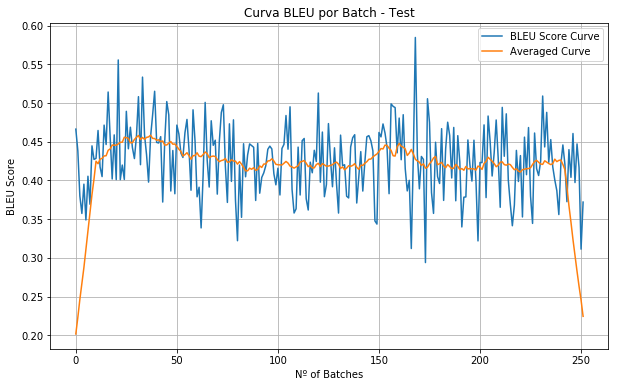

In [93]:
fig = plt.figure()
plt.plot(bleu_scores_test, label="BLEU Score Curve")
#plt.plot(scipy.signal.savgol_filter(bleu_scores_Test, N+1, 3))
plt.plot(movingaverage(bleu_scores_test, 20), label="Averaged Curve")
plt.xlabel('Nº of Batches')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.legend()
plt.title('Curva BLEU por Batch - Test')
plt.show()

## 2.4 Actividad 7

### 2.4.1 Limitaciones

A continuación se comentan tres limitaciones del modelo implementado:

1. Hay limitaciones respecto de la tokenización de los lenguajes de entrada y salida. En particular, hay variabilidad en la presentación que puede tener un token que debería ser el mismo. Por ejemplo: las palabras "en" y "en." deberían ser la misma palabra, y no dos tokens distintos. Esto genera problemas en la traducción, ya que aumenta los grados de libertad del problema de manera innecesaria, aumentando su complejidad.

2. Frases largas con tamaño superior al vector de contexto tienen problemas para traducir correctamente, y tienden a instanciar palabras recurrentes en el lenguaje como "y", "del", "el".

3. No existe ninguna retroalimentación que ayude al traductor a corregirse. En caso de que una sentencia parta mal traducida, de ahi en adelante es muy probable que no se corrija, sino que mas bien siga empeorando.

### 2.4.2 Posibles soluciones

Soluciones para los problemas planteados:

1. Procurar limpiar a cabalidad los datos a ser utilizados. Así, los tokens generados serán más significativos.
2. Es posible introducir un vector de contexto intermeddio que no sea de tamaño fijo, sino que mñas bien sea de tamaño variable. También se podría penalizar la aparición de palabras repetidas.
3. Se pueden utilizar métodos como Professor Forcing, que durante el entrenamiento ayudan a la red a corregir sus errores de manera aleatoria, perfeccionando su capacidad de aprender a tiempo a medida que realiza predicciones. Esto permitirá poder tratar con frases más largas en las cuales se equivoca en el transcurso de su predicción, ya que una equivocación a la mitad de la frase puede ser corregida durante entrenamiento, ayudando a la red a desempeñarse mejor en el futuro [4]. 


## 3. Referencias

[1] Neural Machine Translation with Attention Using PyTorch
In t. Disponible en: https://colab.research.google.com/drive/1uFJBO1pgsiFwCGIJwZlhUzaJ2srDbtw-#scrollTo=cl4ZgMd-KyTU

[2] Sequence to Sequence Learning with Neural Networks. Disponible en: https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb

[3] A Gentle Introduction to Calculating the BLEU Score for Text in Python. Disponible en: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

[4] Professor Forcing: A New Algorithm for Training Recurrent Networks. Disponible en: https://arxiv.org/abs/1610.09038
